# Benchmark for Clustering

In [1]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import extract_labels_from_communities, time_tester, calculate_scores_clustering

from LocalStable import locally_stable_clustering_with_euclid_graphs

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_pos_labels

from PlotHelperFunctions import plot_clustering, plot_stuff

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons, load_breast_cancer, load_iris
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity



## Create Graphs

In [2]:
repetitions = 1    #Number of random isomorph permutation for each graph


moon_agents,moon_truth = make_moons(n_samples=300, noise=0.05)
moon_perm_agents = []
moon_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(moon_agents,moon_truth)
    moon_perm_agents += [g]
    moon_perm_truth += [t]



circle_agents, circle_truth = my_make_circles(300)

circle_perm_agents = []
circle_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(circle_agents,circle_truth)
    circle_perm_agents += [g]
    circle_perm_truth += [t]

cancer = load_breast_cancer()

cancer_agents = cancer['data']
cancer_truth = cancer['target']

cancer_perm_agents = []
cancer_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(cancer_agents,cancer_truth)
    cancer_perm_agents += [g]
    cancer_perm_truth += [t]

iris = load_iris()
iris_agents = iris['data']
iris_truth = iris['target']


iris_perm_agents = []
iris_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(iris_agents,iris_truth)
    iris_perm_agents += [g]
    iris_perm_truth += [t]


## Run the algorithms


In [3]:
import itertools
import timeit

import pandas as pd
import numbers

dfs = []
labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)]

for treshold in labels:
    collected_data = {}
    for repetitions in range(10):
        f = treshold[0]   #f-bound
        e = treshold[1]   

        data = [ moon_perm_agents,circle_perm_agents,cancer_perm_agents,iris_perm_agents]
        expected_clusters = [2,3,2,3]
        graph_names = ['Moons','My 3 Circles', 'Cancer', 'Iris']
        graph_truths =  [moon_perm_truth,circle_perm_truth,cancer_perm_truth,iris_perm_truth]
        
        
        kmeans = lambda agents, clusters: KMeans(n_clusters = clusters).fit_predict(agents)
        dbscan = lambda agents, clusters: DBSCAN(eps=0.2, min_samples=5).fit_predict(agents)
        
        kmeans_out = None
        dbscan_out = None
        
        lp_a_b =lambda agents, initial_clustering, pre, allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering,allow_exit,mode='B',pre=pre)
        lp_a_f =lambda agents, initial_clustering, pre, allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering, allow_exit, mode='F',pre=pre)
        lp_a_e =lambda agents, initial_clustering, pre, allow_exit: locally_stable_clustering_with_euclid_graphs(agents, f, e, initial_clustering, allow_exit, mode='E',pre=pre)
        
        algorithms = [ kmeans, dbscan,lp_a_b,lp_a_f,lp_a_e]
        algo_names = [ 'kmeans', 'dbscan','LS (Balanced) Heuristic',\
                       'LS (Friend-Oriented) Heuristic','LS (Enemy-Averse) Heuristic']
        is_lp_heuristic = [False,False,True, True, True]
        
       

        for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
            itertools.product(zip(data, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
        
                
            agents = graph
        
            if lp_heuristic:
                # start with everyone alone
                a_name_modified = a_name + ' starting with everyone alone'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                allow_exit = False
                test_callable = lambda a: list(algo(a,len(agents[0]),None,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                # start with random clustering 
        
                a_name_modified = a_name + ' starting with predicted number of clusters'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                allow_exit = False
                test_callable = lambda a: list(algo(a,clusters,None,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
        
                # start with the output of k-means
                a_name_modified = a_name + ' starting with the output of k-means'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                allow_exit = False
                test_callable = lambda a: list(algo(a,clusters,kmeans,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
        
                rand_score_with_init = sum(rand_score(out, k) for out, k in zip(outputs, kmeans_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores['Time'] = avg_time

                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                # start with the output of dbscan
                a_name_modified = a_name + ' starting with the output of dbscan'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                allow_exit = False
                test_callable = lambda a: list(algo(a,clusters,dbscan,allow_exit).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
        
                rand_score_with_init = sum(rand_score(out, db) for out, db in zip(outputs, dbscan_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                   
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))

            
            else:
        
                print(f"Running {a_name} on {g_name} … ", end='')
                test_callable = lambda a : algo(a, clusters)
                    
                times,outputs = time_tester(test_callable,graph)
                if(algo == kmeans):
                    kmeans_out = outputs
                if(algo == dbscan):
                    dbscan_out = outputs
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
                
                if (a_name, g_name) not in collected_data:
                    collected_data[(a_name, g_name)] = []
                collected_data[(a_name, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))

    records = []

    for (method, dataset), metrics_list in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        keys = metrics_list[0].keys()
        for key in keys:
            # check if this metric is numeric
            if isinstance(metrics_list[0][key], numbers.Number):
                values = [m[key] for m in metrics_list]
                mean = sum(values) / len(values)
                std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
                record[key] = (mean, std)
            else:
                # if not numeric (e.g., a string), just copy one of them
                record[key] = metrics_list[0][key]
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)

dfs[0].head()


Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.413826 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.4138255000070785
Running dbscan on Moons … execution time: ~ 0.008723 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.008723099999770056
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.038270 seconds.
Rand Index : ~ 0.6435674470457079
Silhouette Score : ~ 0.49209171157859694
Davies Bouldin Score : ~ 0.6135054742144709
Time : ~ 8.038270199998806
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.622700 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Time : ~ 0.6226996999976109
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.627331 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.627330900002562
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.642685 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.6426852000004146
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.360107 seconds.
Rand Index : ~ 0.6533556298773691
Silhouette Score : ~ 0.3890787693220051
Davies Bouldin Score : ~ 0.6000752526433333
Time : ~ 8.360107499996957
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.630318 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.594961 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5949608999944758
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.598551 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.598551300005056
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.112942 seconds.
Rand Index : ~ 0.5968115942028985
Silhouette Score : ~ 0.07498080749730564
Davies Bouldin Score : ~ 0.6299230160482944
Time : ~ 8.112941899998987
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.825138 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.658059 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.6580589999939548
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.589423 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5894233999933931
Running kmeans on My 3 Circles … execution time: ~ 0.006888 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.00688800000352785
Running dbscan on My 3 Circles … execution time: ~ 0.004720 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004719799995655194
Running LS (Balanced) Heuristi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.807428 seconds.
Rand Index : ~ 0.7087179487179487
Silhouette Score : ~ 0.336554823300848
Davies Bouldin Score : ~ 0.6843530310760103
Time : ~ 8.807428200001596
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.671494 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Time : ~ 0.6714942999969935
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.639565 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Rand Score with initial clustering : ~ 0.8400445930880713
Time : ~ 0.6395650999984355
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.587077 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5870772000052966
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.983460 seconds.
Rand Index : ~ 0.7093868450390189
Silhouette Score : ~ 0.2842773741195469
Davies Bouldin Score : ~ 0.70504961413758
Time : ~ 8.983460499999637
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.664410 seconds.
Rand Index : ~ 0.7187068004459308
Silhouette Score : ~ 0.37807868468341466
Dav

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.598859 seconds.
Rand Index : ~ 0.7125752508361204
Silhouette Score : ~ 0.4094240545296652
Davies Bouldin Score : ~ 1.1454000123612265
Rand Score with initial clustering : ~ 0.8309476031215162
Time : ~ 0.5988586000021314
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.556545 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5565447999979369
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.957952 seconds.
Rand Index : ~ 0.6962541806020067
Silhouette Score : ~ 0.1326734729447936
Davies Bouldin Score : ~ 0.9608540156721518
Time : ~ 7.957952400000067
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.838612 seconds.
Rand Index : ~ 0.680891861761427
Silhouette Score : ~ 0.24281780424398533


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.597782 seconds.
Rand Index : ~ 0.7532218506131549
Silhouette Score : ~ 0.40173915982155844
Davies Bouldin Score : ~ 1.0019599813246007
Rand Score with initial clustering : ~ 0.9771460423634337
Time : ~ 0.5977818000028492
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.558050 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.558050199993886
Running kmeans on Cancer … execution time: ~ 0.007753 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007752700003038626
Running dbscan on Cancer … execution time: ~ 0.019755 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.01975519999541575
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 58.046192 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 58.04619150000508
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.082477 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Time : ~ 2.08247740000661
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.121509 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.12150880000263
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.924086 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.924085799997556
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 65.182004 seconds.
Rand Index : ~ 0.6665078343523354
Silhouette Score : ~ 0.6606328598747512
Davies Bouldin Score : ~ 0.4258306031751288
Time : ~ 65.18200350000552
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.177873 seconds.
Rand Index : ~ 0.633753310725513
Silhouette Score : ~ 0.6642676658427622
Davies Bouldin Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.989692 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.989692000002833
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 2.039578 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.039578199997777
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.432326 seconds.
Rand Index : ~ 0.7797098938092527
Silhouette Score : ~ 0.25044677578019836
Davies Bouldin Score : ~ 0.7421163015376879
Time : ~ 57.43232649999845
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.062949 seconds.
Rand Index : ~ 0.714361741627268
Silhouette Score : ~ 0.6896770139584167
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.942406 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9424056999996537
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.942658 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9426583999957074
Running kmeans on Iris … execution time: ~ 0.005404 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.005404299998190254
Running dbscan on Iris … execution time: ~ 0.002437 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0024365999997826293
Running LS (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.103131 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749731
Time : ~ 1.1031311000042479
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.205543 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Time : ~ 0.20554299999639625
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.179586 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.17958609999914188
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.173820 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.17382009999710135
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.960033 seconds.
Rand Index : ~ 0.7934675615212528
Silhouette Score : ~ 0.4296505733589562
Davies Bouldin Score : ~ 0.6903431743958377
Time : ~ 0.960033300005307
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.204883 seconds.
Rand Index : ~ 0.7763758389261745
Silhouette Score : ~ 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.171655 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.17165450000175042
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.264322 seconds.
Rand Index : ~ 0.7914093959731544
Silhouette Score : ~ 0.42628629855978584
Davies Bouldin Score : ~ 0.6880023478301308
Rand Score with initial clustering : ~ 0.46702460850111854
Time : ~ 0.2643215999996755
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.045472 seconds.
Rand Index : ~ 0.8137807606263983
Silhouette Score : ~ 0.13224481986097864
Davies Bouldin Score : ~ 0.9696472806101596
Time : ~ 1.0454717000029632
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.207478 seconds.
Rand Index : ~ 0.7766442953020134
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.191093 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.19109349999780534
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.180044 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.1800442000021576
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005727 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.00572719999763649
Running dbscan on Moons … execution time: ~ 0.004903 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.004902799999399576
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.399423 seconds.
Rand Index : ~ 0.6435674470457079
Silhouette Score : ~ 0.49209171157859694
Davies Bouldin Score : ~ 0.6135054742144709
Time : ~ 8.399423200004094
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.609767 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Time : ~ 0.6097666999994544
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.573767 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5737673999974504
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.592256 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.592256299998553
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.787236 seconds.
Rand Index : ~ 0.6533556298773691
Silhouette Score : ~ 0.3890787693220051
Davies Bouldin Score : ~ 0.6000752526433333
Time : ~ 8.787235699994199
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.597226 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.565471 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5654709000009461
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.596476 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5964758999980404
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.998589 seconds.
Rand Index : ~ 0.5968115942028985
Silhouette Score : ~ 0.07498080749730564
Davies Bouldin Score : ~ 0.6299230160482944
Time : ~ 7.998589099996025
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.606824 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.571440 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5714397000047029
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.573957 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5739572000020416
Running kmeans on My 3 Circles … execution time: ~ 0.007249 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.00724869999976363
Running dbscan on My 3 Circles … execution time: ~ 0.004111 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004111499998543877
Running LS (Balanced) Heuristic

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.710675 seconds.
Rand Index : ~ 0.7087179487179487
Silhouette Score : ~ 0.336554823300848
Davies Bouldin Score : ~ 0.6843530310760103
Time : ~ 8.71067509999557
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.751160 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Time : ~ 0.7511599999997998
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.624853 seconds.
Rand Index : ~ 0.6708138238573021
Silhouette Score : ~ 0.24103620600753517
Davies Bouldin Score : ~ 8.291489954339731
Rand Score with initial clustering : ~ 0.798015607580825
Time : ~ 0.6248532000026898
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.595821 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.595821299997624
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.164889 seconds.
Rand Index : ~ 0.7093868450390189
Silhouette Score : ~ 0.2842773741195469
Davies Bouldin Score : ~ 0.70504961413758
Time : ~ 9.164888600003906
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.646153 seconds.
Rand Index : ~ 0.7187068004459308
Silhouette Score : ~ 0.37807868468341466
Davi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.587185 seconds.
Rand Index : ~ 0.74396878483835
Silhouette Score : ~ 0.3849529090422563
Davies Bouldin Score : ~ 0.9510479464343593
Rand Score with initial clustering : ~ 0.7061315496098105
Time : ~ 0.5871850999974413
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.527189 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5271891999946092
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.661061 seconds.
Rand Index : ~ 0.6962541806020067
Silhouette Score : ~ 0.1326734729447936
Davies Bouldin Score : ~ 0.9608540156721518
Time : ~ 7.661061300001165
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.656581 seconds.
Rand Index : ~ 0.680891861761427
Silhouette Score : ~ 0.24281780424398533
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.643590 seconds.
Rand Index : ~ 0.7454626532887403
Silhouette Score : ~ 0.39122299149873335
Davies Bouldin Score : ~ 1.136660993895347
Rand Score with initial clustering : ~ 0.9617614269788183
Time : ~ 0.6435902000011993
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.562138 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5621382999961497
Running kmeans on Cancer … execution time: ~ 0.008242 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.008242199997766875
Running dbscan on Cancer … execution time: ~ 0.005833 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0058325000063632615
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 57.979003 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 57.97900349999691
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.068823 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Time : ~ 2.068822799999907
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.946358 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9463582999960636
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.817790 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.817790099994454
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 63.803496 seconds.
Rand Index : ~ 0.6665078343523354
Silhouette Score : ~ 0.6606328598747512
Davies Bouldin Score : ~ 0.4258306031751288
Time : ~ 63.80349649999698
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.204888 seconds.
Rand Index : ~ 0.633753310725513
Silhouette Score : ~ 0.6642676658427622
Davies Bouldin Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.093688 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.093688300003123
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.899043 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8990429000041331
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.454886 seconds.
Rand Index : ~ 0.7797098938092527
Silhouette Score : ~ 0.25044677578019836
Davies Bouldin Score : ~ 0.7421163015376879
Time : ~ 57.454886100000294
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.169995 seconds.
Rand Index : ~ 0.714361741627268
Silhouette Score : ~ 0.6896770139584167
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.957621 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9576214000044274
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 2.031760 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.031759500001499
Running kmeans on Iris … execution time: ~ 0.008129 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.008128599998599384
Running dbscan on Iris … execution time: ~ 0.002576 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0025757999974302948
Running LS (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.092831 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749731
Time : ~ 1.092831499998283
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.206520 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Time : ~ 0.2065202000012505
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173675 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.1736754999947152
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.180248 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.18024769999465207
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.018759 seconds.
Rand Index : ~ 0.7934675615212528
Silhouette Score : ~ 0.4296505733589562
Davies Bouldin Score : ~ 0.6903431743958377
Time : ~ 1.0187593000009656
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.186287 seconds.
Rand Index : ~ 0.7763758389261745
Silhouette Score : ~ 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.195247 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.19524700000329176
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.263349 seconds.
Rand Index : ~ 0.7914093959731544
Silhouette Score : ~ 0.42628629855978584
Davies Bouldin Score : ~ 0.6880023478301308
Rand Score with initial clustering : ~ 0.46702460850111854
Time : ~ 0.26334879999922123
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.984854 seconds.
Rand Index : ~ 0.8137807606263983
Silhouette Score : ~ 0.13224481986097864
Davies Bouldin Score : ~ 0.9696472806101596
Time : ~ 0.9848535999990418
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201089 seconds.
Rand Index : ~ 0.7766442953020134
Silhouette Score : ~ 0.4537662

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.185676 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.18567609999445267
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.166078 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.16607800000201678
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005988 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.005988400000205729
Running dbscan on Moons … execution time: ~ 0.004549 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.0045489000040106475
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.553446 seconds.
Rand Index : ~ 0.6435674470457079
Silhouette Score : ~ 0.49209171157859694
Davies Bouldin Score : ~ 0.6135054742144709
Time : ~ 8.553445600002306
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.652317 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Time : ~ 0.6523168999992777
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.633171 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.6331712999963202
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.582586 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5825861999983317
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.231783 seconds.
Rand Index : ~ 0.6533556298773691
Silhouette Score : ~ 0.3890787693220051
Davies Bouldin Score : ~ 0.6000752526433333
Time : ~ 8.231783499999437
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.595817 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.584812 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5848121000017272
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.568225 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5682247999939136
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.799987 seconds.
Rand Index : ~ 0.5968115942028985
Silhouette Score : ~ 0.07498080749730564
Davies Bouldin Score : ~ 0.6299230160482944
Time : ~ 7.7999867999969865
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.584140 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.597570 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5975700999988476
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.566768 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5667678000027081
Running kmeans on My 3 Circles … execution time: ~ 0.007691 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.00769100000616163
Running dbscan on My 3 Circles … execution time: ~ 0.004329 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004329400006099604
Running LS (Balanced) Heuristic

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.287266 seconds.
Rand Index : ~ 0.7087179487179487
Silhouette Score : ~ 0.336554823300848
Davies Bouldin Score : ~ 0.6843530310760103
Time : ~ 8.287265599996317
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.814456 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Time : ~ 0.8144555000035325
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.615172 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Rand Score with initial clustering : ~ 0.8268896321070234
Time : ~ 0.6151719000044977
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.595431 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5954311000023154
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.960978 seconds.
Rand Index : ~ 0.7093868450390189
Silhouette Score : ~ 0.2842773741195469
Davies Bouldin Score : ~ 0.70504961413758
Time : ~ 8.960978199997044
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.669353 seconds.
Rand Index : ~ 0.7187068004459308
Silhouette Score : ~ 0.37807868468341466
Dav

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.561188 seconds.
Rand Index : ~ 0.7467335562987737
Silhouette Score : ~ 0.42642011241365396
Davies Bouldin Score : ~ 0.879424990331673
Rand Score with initial clustering : ~ 0.9605797101449275
Time : ~ 0.561188100000436
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.518972 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5189716999957454
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.687383 seconds.
Rand Index : ~ 0.6962541806020067
Silhouette Score : ~ 0.1326734729447936
Davies Bouldin Score : ~ 0.9608540156721518
Time : ~ 7.687383399999817
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.650939 seconds.
Rand Index : ~ 0.680891861761427
Silhouette Score : ~ 0.24281780424398533
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570193 seconds.
Rand Index : ~ 0.7532218506131549
Silhouette Score : ~ 0.40173915982155844
Davies Bouldin Score : ~ 1.0019599813246007
Rand Score with initial clustering : ~ 0.9874470457079153
Time : ~ 0.5701927999980398
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.549906 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5499064999967231
Running kmeans on Cancer … execution time: ~ 0.007449 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007449400000041351
Running dbscan on Cancer … execution time: ~ 0.006714 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006714300005114637
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 58.421261 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 58.42126070000086
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.269557 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Time : ~ 2.269556699997338
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.957025 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.957025200004864
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.927657 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.927657199994428
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.686634 seconds.
Rand Index : ~ 0.6665078343523354
Silhouette Score : ~ 0.6606328598747512
Davies Bouldin Score : ~ 0.4258306031751288
Time : ~ 64.6866336000021
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.068367 seconds.
Rand Index : ~ 0.633753310725513
Silhouette Score : ~ 0.6642676658427622
Davies Bouldin Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.931450 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9314500000036787
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.886588 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8865876000054413
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.964700 seconds.
Rand Index : ~ 0.7797098938092527
Silhouette Score : ~ 0.25044677578019836
Davies Bouldin Score : ~ 0.7421163015376879
Time : ~ 56.96469979999529
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.947863 seconds.
Rand Index : ~ 0.714361741627268
Silhouette Score : ~ 0.6896770139584167
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.886835 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8868354000005638
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.877967 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8779665999973076
Running kmeans on Iris … execution time: ~ 0.006607 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.006606900002225302
Running dbscan on Iris … execution time: ~ 0.002451 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0024506999980076216
Running LS (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.087083 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749731
Time : ~ 1.087082800004282
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.305238 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Time : ~ 0.3052384000038728
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … execution time: ~ 0.176920 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.17691979999653995
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.153206 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.15320629999769153
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.127008 seconds.
Rand Index : ~ 0.7934675615212528
Silhouette Score : ~ 0.4296505733589562
Davies Bouldin Score : ~ 0.6903431743958377
Time : ~ 1.1270075000065845
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.197453 seconds.
Rand Index : ~ 0.7763758389261745
Silhouette Score : ~ 0.48222513608876566
Davies Bouldin Score : ~ 17.73701563065489
Time : ~ 0.1974534999972093
Running LS (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.194196 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.194196299999021
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.250285 seconds.
Rand Index : ~ 0.7914093959731544
Silhouette Score : ~ 0.42628629855978584
Davies Bouldin Score : ~ 0.6880023478301308
Rand Score with initial clustering : ~ 0.46702460850111854
Time : ~ 0.25028520000341814
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.166154 seconds.
Rand Index : ~ 0.8137807606263983
Silhouette Score : ~ 0.13224481986097864
Davies Bouldin Score : ~ 0.9696472806101596
Time : ~ 1.1661539000051562
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.210899 seconds.
Rand Index : ~ 0.7766442953020134
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.196963 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.1969630000021425
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.207014 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.20701419999386417
Running kmeans on Moons … execution time: ~ 0.006284 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.006284199997026008
Running dbscan on Moons … execution time: ~ 0.003597 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.0035972999976365827
Running LS (Balanced) Heuristic 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.472043 seconds.
Rand Index : ~ 0.6435674470457079
Silhouette Score : ~ 0.49209171157859694
Davies Bouldin Score : ~ 0.6135054742144709
Time : ~ 8.472042500005045
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.741935 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Time : ~ 0.7419353000004776
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.551882 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5518819999997504
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.536465 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5364647999958834
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.710434 seconds.
Rand Index : ~ 0.6533556298773691
Silhouette Score : ~ 0.3890787693220051
Davies Bouldin Score : ~ 0.6000752526433333
Time : ~ 8.71043389999977
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.603879 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.556304 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.556304400000954
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.560493 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5604930999979842
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.031448 seconds.
Rand Index : ~ 0.5968115942028985
Silhouette Score : ~ 0.07498080749730564
Davies Bouldin Score : ~ 0.6299230160482944
Time : ~ 8.031448499998078
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.612909 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.633841 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.6338405999995302
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.550572 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5505722999951104
Running kmeans on My 3 Circles … execution time: ~ 0.007922 seconds.
Rand Index : ~ 0.7623857302118172
Silhouette Score : ~ 0.41788810158220674
Davies Bouldin Score : ~ 0.8906496005177692
Time : ~ 0.007921899996290449
Running dbscan on My 3 Circles … execution time: ~ 0.004850 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0048504000005777925
Running LS (Balanced) Heuris

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.708118 seconds.
Rand Index : ~ 0.7087179487179487
Silhouette Score : ~ 0.336554823300848
Davies Bouldin Score : ~ 0.6843530310760103
Time : ~ 8.70811789999425
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.667052 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Time : ~ 0.6670521999985795
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.603886 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Rand Score with initial clustering : ~ 0.8341583054626532
Time : ~ 0.6038856999948621
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.592387 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5923868999961996
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.098026 seconds.
Rand Index : ~ 0.7093868450390189
Silhouette Score : ~ 0.2842773741195469
Davies Bouldin Score : ~ 0.70504961413758
Time : ~ 9.098026499996195
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.722604 seconds.
Rand Index : ~ 0.7187068004459308
Silhouette Score : ~ 0.37807868468341466
Dav

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.613067 seconds.
Rand Index : ~ 0.7467335562987737
Silhouette Score : ~ 0.42642011241365396
Davies Bouldin Score : ~ 0.879424990331673
Rand Score with initial clustering : ~ 0.9707915273132665
Time : ~ 0.6130670000056853
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.562557 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5625571999989916
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.555365 seconds.
Rand Index : ~ 0.6962541806020067
Silhouette Score : ~ 0.1326734729447936
Davies Bouldin Score : ~ 0.9608540156721518
Time : ~ 7.555365100000927
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.592179 seconds.
Rand Index : ~ 0.680891861761427
Silhouette Score : ~ 0.24281780424398533


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.574224 seconds.
Rand Index : ~ 0.7454626532887403
Silhouette Score : ~ 0.39122299149873335
Davies Bouldin Score : ~ 1.136660993895347
Rand Score with initial clustering : ~ 0.971705685618729
Time : ~ 0.5742239000028349
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.540848 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5408483999999589
Running kmeans on Cancer … execution time: ~ 0.006556 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.006556299995281734
Running dbscan on Cancer … execution time: ~ 0.005847 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005846599997312296
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 57.968165 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 57.96816519999993
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.085361 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Time : ~ 2.0853611000056844
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.912492 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.912492099996598
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.884853 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.884852699993644
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.283324 seconds.
Rand Index : ~ 0.6665078343523354
Silhouette Score : ~ 0.6606328598747512
Davies Bouldin Score : ~ 0.4258306031751288
Time : ~ 64.2833243999994
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.175922 seconds.
Rand Index : ~ 0.633753310725513
Silhouette Score : ~ 0.6642676658427622
Davies Bouldin Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.977110 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9771101000005729
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.897106 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8971056000009412
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.109705 seconds.
Rand Index : ~ 0.7797098938092527
Silhouette Score : ~ 0.25044677578019836
Davies Bouldin Score : ~ 0.7421163015376879
Time : ~ 57.109704900001816
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.159735 seconds.
Rand Index : ~ 0.714361741627268
Silhouette Score : ~ 0.6896770139584167
Davies Bouldin Sc

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.095494 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.0954939000002923
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.925090 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9250897000019904
Running kmeans on Iris … execution time: ~ 0.006640 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.006639500003075227
Running dbscan on Iris … execution time: ~ 0.003487 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.003487200003291946
Running LS (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.085439 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749731
Time : ~ 1.0854393999979948
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.186760 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Time : ~ 0.1867595000003348
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.186418 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.186418400000548
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.185295 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.18529549999948358
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.007881 seconds.
Rand Index : ~ 0.7934675615212528
Silhouette Score : ~ 0.4296505733589562
Davies Bouldin Score : ~ 0.6903431743958377
Time : ~ 1.007880599994678
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.203730 seconds.
Rand Index : ~ 0.7763758389261745
Silhouette Score : ~ 0.

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.181499 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.1814989999984391
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.259117 seconds.
Rand Index : ~ 0.7914093959731544
Silhouette Score : ~ 0.42628629855978584
Davies Bouldin Score : ~ 0.6880023478301308
Rand Score with initial clustering : ~ 0.46702460850111854
Time : ~ 0.259116900000663
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.064128 seconds.
Rand Index : ~ 0.8137807606263983
Silhouette Score : ~ 0.13224481986097864
Davies Bouldin Score : ~ 0.9696472806101596
Time : ~ 1.0641277999966405
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.190110 seconds.
Rand Index : ~ 0.7766442953020134
Silhouette Score : ~ 0.4537662933

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.189751 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.18975059999502264
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.189090 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.18908980000560405
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005302 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.005302400000800844
Running dbscan on Moons … execution time: ~ 0.004144 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.0041438999978709035
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.507822 seconds.
Rand Index : ~ 0.6435674470457079
Silhouette Score : ~ 0.49209171157859694
Davies Bouldin Score : ~ 0.6135054742144709
Time : ~ 8.507821999999578
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.650741 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Time : ~ 0.6507410999984131
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.613946 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.613945800003421
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.548509 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5485087999986717
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.086911 seconds.
Rand Index : ~ 0.6533556298773691
Silhouette Score : ~ 0.3890787693220051
Davies Bouldin Score : ~ 0.6000752526433333
Time : ~ 8.08691149999504
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.581720 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.588345 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5883451999980025
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.573337 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5733369000008679
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.654915 seconds.
Rand Index : ~ 0.5968115942028985
Silhouette Score : ~ 0.07498080749730564
Davies Bouldin Score : ~ 0.6299230160482944
Time : ~ 7.65491540000221
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.702940 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.575169 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5751692999983788
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.564579 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5645789000045625
Running kmeans on My 3 Circles … execution time: ~ 0.011964 seconds.
Rand Index : ~ 0.7626755852842809
Silhouette Score : ~ 0.37248497966327276
Davies Bouldin Score : ~ 0.9782403920257998
Time : ~ 0.011963799996010493
Running dbscan on My 3 Circles … execution time: ~ 0.004256 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00425550000363728
Running LS (Balanced) Heuristi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.191080 seconds.
Rand Index : ~ 0.7087179487179487
Silhouette Score : ~ 0.336554823300848
Davies Bouldin Score : ~ 0.6843530310760103
Time : ~ 8.191079600001103
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.650671 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Time : ~ 0.6506714999995893
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.648200 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Rand Score with initial clustering : ~ 0.6847491638795986
Time : ~ 0.6482000999967568
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.584640 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5846397999994224
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.746355 seconds.
Rand Index : ~ 0.7093868450390189
Silhouette Score : ~ 0.2842773741195469
Davies Bouldin Score : ~ 0.70504961413758
Time : ~ 8.746354700000666
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.615078 seconds.
Rand Index : ~ 0.7187068004459308
Silhouette Score : ~ 0.37807868468341466
Dav

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.585204 seconds.
Rand Index : ~ 0.7467335562987737
Silhouette Score : ~ 0.42642011241365396
Davies Bouldin Score : ~ 0.879424990331673
Rand Score with initial clustering : ~ 0.707670011148272
Time : ~ 0.585204299997713
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.550905 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5509049999964191
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.950083 seconds.
Rand Index : ~ 0.6962541806020067
Silhouette Score : ~ 0.1326734729447936
Davies Bouldin Score : ~ 0.9608540156721518
Time : ~ 7.950083200004883
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.781380 seconds.
Rand Index : ~ 0.680891861761427
Silhouette Score : ~ 0.24281780424398533
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.639812 seconds.
Rand Index : ~ 0.7454626532887403
Silhouette Score : ~ 0.39122299149873335
Davies Bouldin Score : ~ 1.136660993895347
Rand Score with initial clustering : ~ 0.7028316610925307
Time : ~ 0.6398120000012568
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.590720 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5907195999971009
Running kmeans on Cancer … execution time: ~ 0.008081 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.008080799998424482
Running dbscan on Cancer … execution time: ~ 0.007772 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.007771800002956297
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 57.185714 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 57.18571399999928
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.215864 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Time : ~ 2.2158637000029557
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.162018 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.1620175000061863
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.843837 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8438366999980644
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.478619 seconds.
Rand Index : ~ 0.6665078343523354
Silhouette Score : ~ 0.6606328598747512
Davies Bouldin Score : ~ 0.4258306031751288
Time : ~ 64.47861929999635
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.092644 seconds.
Rand Index : ~ 0.633753310725513
Silhouette Score : ~ 0.6642676658427622
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.952388 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9523884000009275
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.796706 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.7967060000009951
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.250078 seconds.
Rand Index : ~ 0.7797098938092527
Silhouette Score : ~ 0.25044677578019836
Davies Bouldin Score : ~ 0.7421163015376879
Time : ~ 57.250078199998825
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.127320 seconds.
Rand Index : ~ 0.714361741627268
Silhouette Score : ~ 0.6896770139584167
Davies Bouldin Sc

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.874209 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8742086999991443
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.837737 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8377367999928538
Running kmeans on Iris … execution time: ~ 0.006678 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.006677800003672019
Running dbscan on Iris … execution time: ~ 0.002574 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.00257390000479063
Running LS (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.046712 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749731
Time : ~ 1.0467120000030263
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.192671 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Time : ~ 0.19267050000053132
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.167495 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.1674949000007473
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.181119 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.18111920000228565
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.142112 seconds.
Rand Index : ~ 0.7934675615212528
Silhouette Score : ~ 0.4296505733589562
Davies Bouldin Score : ~ 0.6903431743958377
Time : ~ 1.1421117999998387
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.206247 seconds.
Rand Index : ~ 0.7763758389261745
Silhouette Score : ~ 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.174167 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.1741665000008652
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.275584 seconds.
Rand Index : ~ 0.7914093959731544
Silhouette Score : ~ 0.42628629855978584
Davies Bouldin Score : ~ 0.6880023478301308
Rand Score with initial clustering : ~ 0.46702460850111854
Time : ~ 0.2755840000027092
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.014454 seconds.
Rand Index : ~ 0.8137807606263983
Silhouette Score : ~ 0.13224481986097864
Davies Bouldin Score : ~ 0.9696472806101596
Time : ~ 1.0144540999972378
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.199619 seconds.
Rand Index : ~ 0.7766442953020134
Silhouette Score : ~ 0.453766293

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.191417 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.19141710000258172
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.195852 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.19585150000057183
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.006106 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.006106300003011711
Running dbscan on Moons … execution time: ~ 0.004163 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.004163199999311473
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.581933 seconds.
Rand Index : ~ 0.6435674470457079
Silhouette Score : ~ 0.49209171157859694
Davies Bouldin Score : ~ 0.6135054742144709
Time : ~ 8.581932799999777
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.587225 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Time : ~ 0.587224699993385
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.563448 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5634481000015512
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.551680 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5516798000026029
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.369263 seconds.
Rand Index : ~ 0.6533556298773691
Silhouette Score : ~ 0.3890787693220051
Davies Bouldin Score : ~ 0.6000752526433333
Time : ~ 8.369263100001263
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.735742 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.614992 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.6149919999952544
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.593080 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5930796000029659
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.001849 seconds.
Rand Index : ~ 0.5968115942028985
Silhouette Score : ~ 0.07498080749730564
Davies Bouldin Score : ~ 0.6299230160482944
Time : ~ 8.001849300002505
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.639664 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.657371 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.6573707999996259
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.575496 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5754958999968949
Running kmeans on My 3 Circles … execution time: ~ 0.007414 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.007414499996230006
Running dbscan on My 3 Circles … execution time: ~ 0.004234 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004233899999235291
Running LS (Balanced) Heurist

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.570423 seconds.
Rand Index : ~ 0.7087179487179487
Silhouette Score : ~ 0.336554823300848
Davies Bouldin Score : ~ 0.6843530310760103
Time : ~ 8.570423100005428
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.620712 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Time : ~ 0.6207118000020273
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.633008 seconds.
Rand Index : ~ 0.6708138238573021
Silhouette Score : ~ 0.24103620600753517
Davies Bouldin Score : ~ 8.291489954339731
Rand Score with initial clustering : ~ 0.8100111482720178
Time : ~ 0.6330077000020538
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.546157 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5461566000012681
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.025927 seconds.
Rand Index : ~ 0.7093868450390189
Silhouette Score : ~ 0.2842773741195469
Davies Bouldin Score : ~ 0.70504961413758
Time : ~ 9.02592650000588
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.770156 seconds.
Rand Index : ~ 0.7187068004459308
Silhouette Score : ~ 0.37807868468341466
Dav

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.563751 seconds.
Rand Index : ~ 0.7598885172798217
Silhouette Score : ~ 0.3781722027336184
Davies Bouldin Score : ~ 0.9643906761041832
Rand Score with initial clustering : ~ 0.7041248606465997
Time : ~ 0.5637506999992183
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.547196 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5471958999987692
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.923362 seconds.
Rand Index : ~ 0.6962541806020067
Silhouette Score : ~ 0.1326734729447936
Davies Bouldin Score : ~ 0.9608540156721518
Time : ~ 7.9233621999956085
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.657433 seconds.
Rand Index : ~ 0.680891861761427
Silhouette Score : ~ 0.24281780424398533

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570314 seconds.
Rand Index : ~ 0.7454626532887403
Silhouette Score : ~ 0.39122299149873335
Davies Bouldin Score : ~ 1.136660993895347
Rand Score with initial clustering : ~ 0.9787513935340022
Time : ~ 0.5703140000041458
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.547308 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.547307599998021
Running kmeans on Cancer … execution time: ~ 0.010267 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.010267300000123214
Running dbscan on Cancer … execution time: ~ 0.006751 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006751300003088545
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 57.904640 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 57.90464020000218
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.033541 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Time : ~ 2.0335412999993423
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.005023 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.005022800003644
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.887127 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8871272999967914
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.309537 seconds.
Rand Index : ~ 0.6665078343523354
Silhouette Score : ~ 0.6606328598747512
Davies Bouldin Score : ~ 0.4258306031751288
Time : ~ 64.30953720000252
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.171311 seconds.
Rand Index : ~ 0.633753310725513
Silhouette Score : ~ 0.6642676658427622
Davies Bouldin Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.054467 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.0544665999987046
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.998849 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9988492999982554
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.702964 seconds.
Rand Index : ~ 0.7797098938092527
Silhouette Score : ~ 0.25044677578019836
Davies Bouldin Score : ~ 0.7421163015376879
Time : ~ 56.70296370000142
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.098257 seconds.
Rand Index : ~ 0.714361741627268
Silhouette Score : ~ 0.6896770139584167
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.029602 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.0296020999958273
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.967615 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9676145999983419
Running kmeans on Iris … execution time: ~ 0.004962 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.004961500002536923
Running dbscan on Iris … execution time: ~ 0.002435 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.002434599999105558
Running LS (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.046536 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749731
Time : ~ 1.0465358000001288
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.193002 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Time : ~ 0.19300169999769423
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.172159 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.17215869999927236
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.181120 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.18112039999687113
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.024569 seconds.
Rand Index : ~ 0.7934675615212528
Silhouette Score : ~ 0.4296505733589562
Davies Bouldin Score : ~ 0.6903431743958377
Time : ~ 1.0245690000010654
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.205318 seconds.
Rand Index : ~ 0.7763758389261745
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.156474 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.15647419999731937
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.263037 seconds.
Rand Index : ~ 0.7914093959731544
Silhouette Score : ~ 0.42628629855978584
Davies Bouldin Score : ~ 0.6880023478301308
Rand Score with initial clustering : ~ 0.46702460850111854
Time : ~ 0.2630374000000302
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.024344 seconds.
Rand Index : ~ 0.8137807606263983
Silhouette Score : ~ 0.13224481986097864
Davies Bouldin Score : ~ 0.9696472806101596
Time : ~ 1.0243440000049304
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.206214 seconds.
Rand Index : ~ 0.7766442953020134
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.180376 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.18037570000160486
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.178297 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.178296500002034
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005623 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.005623199998808559
Running dbscan on Moons … execution time: ~ 0.004570 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.004569799995806534
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.788998 seconds.
Rand Index : ~ 0.6435674470457079
Silhouette Score : ~ 0.49209171157859694
Davies Bouldin Score : ~ 0.6135054742144709
Time : ~ 8.788997800002107
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.619395 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Time : ~ 0.6193952000030549
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.584500 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5844999000037205
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.576916 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5769160999989253
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.288697 seconds.
Rand Index : ~ 0.6533556298773691
Silhouette Score : ~ 0.3890787693220051
Davies Bouldin Score : ~ 0.6000752526433333
Time : ~ 8.288697199997841
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.593093 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.599678 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5996782000001986
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.601075 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.601074600002903
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.019665 seconds.
Rand Index : ~ 0.5968115942028985
Silhouette Score : ~ 0.07498080749730564
Davies Bouldin Score : ~ 0.6299230160482944
Time : ~ 8.019665399995574
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.717228 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.589641 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5896405999956187
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.559182 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5591820999979973
Running kmeans on My 3 Circles … execution time: ~ 0.006796 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.0067963999972562306
Running dbscan on My 3 Circles … execution time: ~ 0.004394 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00439409999671625
Running LS (Balanced) Heuristi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.114958 seconds.
Rand Index : ~ 0.7087179487179487
Silhouette Score : ~ 0.336554823300848
Davies Bouldin Score : ~ 0.6843530310760103
Time : ~ 8.114958000005572
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.680188 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Time : ~ 0.6801878000042052
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.593583 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Rand Score with initial clustering : ~ 0.8268896321070234
Time : ~ 0.5935832000031951
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.559478 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5594777000005706
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.088775 seconds.
Rand Index : ~ 0.7093868450390189
Silhouette Score : ~ 0.2842773741195469
Davies Bouldin Score : ~ 0.70504961413758
Time : ~ 9.088775100004568
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.662773 seconds.
Rand Index : ~ 0.7187068004459308
Silhouette Score : ~ 0.37807868468341466
Dav

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.600198 seconds.
Rand Index : ~ 0.7467335562987737
Silhouette Score : ~ 0.42642011241365396
Davies Bouldin Score : ~ 0.879424990331673
Rand Score with initial clustering : ~ 0.9605797101449275
Time : ~ 0.6001980000000913
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.534401 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.534400700002152
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.035540 seconds.
Rand Index : ~ 0.6962541806020067
Silhouette Score : ~ 0.1326734729447936
Davies Bouldin Score : ~ 0.9608540156721518
Time : ~ 8.035539600001357
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.742773 seconds.
Rand Index : ~ 0.680891861761427
Silhouette Score : ~ 0.24281780424398533
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.578739 seconds.
Rand Index : ~ 0.7454626532887403
Silhouette Score : ~ 0.39122299149873335
Davies Bouldin Score : ~ 1.136660993895347
Rand Score with initial clustering : ~ 0.9617614269788183
Time : ~ 0.5787385000003269
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.549635 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5496348000015132
Running kmeans on Cancer … execution time: ~ 0.006628 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.006627699993259739
Running dbscan on Cancer … execution time: ~ 0.012171 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.012170999994850717
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 57.674646 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 57.674646100000245
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.164860 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Time : ~ 2.164859600001364
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.130509 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.1305091999965953
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.895854 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8958538000006229
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.295893 seconds.
Rand Index : ~ 0.6665078343523354
Silhouette Score : ~ 0.6606328598747512
Davies Bouldin Score : ~ 0.4258306031751288
Time : ~ 64.29589339999802
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.003486 seconds.
Rand Index : ~ 0.633753310725513
Silhouette Score : ~ 0.6642676658427622
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.949409 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9494092000022647
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.861525 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8615250000002561
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.651915 seconds.
Rand Index : ~ 0.7797098938092527
Silhouette Score : ~ 0.25044677578019836
Davies Bouldin Score : ~ 0.7421163015376879
Time : ~ 56.65191490000143
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.035948 seconds.
Rand Index : ~ 0.714361741627268
Silhouette Score : ~ 0.6896770139584167
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.977260 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9772597999981372
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.862293 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.862293400001363
Running kmeans on Iris … execution time: ~ 0.007205 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.007204999994428363
Running dbscan on Iris … execution time: ~ 0.002507 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0025066000016522594
Running LS (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.181642 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749731
Time : ~ 1.1816419000024325
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.208188 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Time : ~ 0.20818750000034925
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.181906 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.18190599999797996
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.167027 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.16702719999739202
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.045314 seconds.
Rand Index : ~ 0.7934675615212528
Silhouette Score : ~ 0.4296505733589562
Davies Bouldin Score : ~ 0.6903431743958377
Time : ~ 1.0453139999954146
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.213049 seconds.
Rand Index : ~ 0.7763758389261745
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.174113 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.17411259999789763
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.257268 seconds.
Rand Index : ~ 0.7914093959731544
Silhouette Score : ~ 0.42628629855978584
Davies Bouldin Score : ~ 0.6880023478301308
Rand Score with initial clustering : ~ 0.46702460850111854
Time : ~ 0.2572680999946897
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.059894 seconds.
Rand Index : ~ 0.8137807606263983
Silhouette Score : ~ 0.13224481986097864
Davies Bouldin Score : ~ 0.9696472806101596
Time : ~ 1.0598937999966438
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.182925 seconds.
Rand Index : ~ 0.7766442953020134
Silhouette Score : ~ 0.45376629

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.175642 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.17564150000544032
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.171810 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.1718096999975387
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.004675 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.004675399999541696
Running dbscan on Moons … execution time: ~ 0.004181 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.0041812999988906085
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.239061 seconds.
Rand Index : ~ 0.6435674470457079
Silhouette Score : ~ 0.49209171157859694
Davies Bouldin Score : ~ 0.6135054742144709
Time : ~ 8.239060699997935
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.718130 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Time : ~ 0.7181295999980648
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.594789 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5947888000009698
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.532820 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5328202999953646
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.558190 seconds.
Rand Index : ~ 0.6533556298773691
Silhouette Score : ~ 0.3890787693220051
Davies Bouldin Score : ~ 0.6000752526433333
Time : ~ 8.558189900002617
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.573628 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.629606 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.6296056999999564
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.558095 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.558094699998037
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.923024 seconds.
Rand Index : ~ 0.5968115942028985
Silhouette Score : ~ 0.07498080749730564
Davies Bouldin Score : ~ 0.6299230160482944
Time : ~ 7.923024499999883
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.581142 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.608207 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.6082071999990148
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.578442 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.578441899997415
Running kmeans on My 3 Circles … execution time: ~ 0.006297 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.006296500003372785
Running dbscan on My 3 Circles … execution time: ~ 0.004134 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004134100003284402
Running LS (Balanced) Heuristic

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.884439 seconds.
Rand Index : ~ 0.7087179487179487
Silhouette Score : ~ 0.336554823300848
Davies Bouldin Score : ~ 0.6843530310760103
Time : ~ 8.88443879999977
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.640360 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Time : ~ 0.6403598000033526
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.593850 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Rand Score with initial clustering : ~ 0.8268896321070234
Time : ~ 0.5938500999982352
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.538018 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5380177999977604
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.849025 seconds.
Rand Index : ~ 0.7093868450390189
Silhouette Score : ~ 0.2842773741195469
Davies Bouldin Score : ~ 0.70504961413758
Time : ~ 8.849025100003928
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.779489 seconds.
Rand Index : ~ 0.7187068004459308
Silhouette Score : ~ 0.37807868468341466
Dav

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.642072 seconds.
Rand Index : ~ 0.7467335562987737
Silhouette Score : ~ 0.42642011241365396
Davies Bouldin Score : ~ 0.879424990331673
Rand Score with initial clustering : ~ 0.9605797101449275
Time : ~ 0.6420722999973805
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.604509 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.6045094000000972
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.736781 seconds.
Rand Index : ~ 0.6962541806020067
Silhouette Score : ~ 0.1326734729447936
Davies Bouldin Score : ~ 0.9608540156721518
Time : ~ 7.736781300001894
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.640341 seconds.
Rand Index : ~ 0.680891861761427
Silhouette Score : ~ 0.24281780424398533


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.599610 seconds.
Rand Index : ~ 0.7454626532887403
Silhouette Score : ~ 0.39122299149873335
Davies Bouldin Score : ~ 1.136660993895347
Rand Score with initial clustering : ~ 0.9617614269788183
Time : ~ 0.5996098000032362
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.567898 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5678980000011506
Running kmeans on Cancer … execution time: ~ 0.008177 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.008176500006811693
Running dbscan on Cancer … execution time: ~ 0.006697 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00669719999859808
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 57.684367 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 57.68436700000166
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.149156 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Time : ~ 2.1491559999994934
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.062874 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.062873800001398
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.949276 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.949276400002418
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.312664 seconds.
Rand Index : ~ 0.6665078343523354
Silhouette Score : ~ 0.6606328598747512
Davies Bouldin Score : ~ 0.4258306031751288
Time : ~ 64.31266350000078
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.990450 seconds.
Rand Index : ~ 0.633753310725513
Silhouette Score : ~ 0.6642676658427622
Davies Bouldin Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.159510 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.1595102999999654
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.989280 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.989280100002361
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.103557 seconds.
Rand Index : ~ 0.7797098938092527
Silhouette Score : ~ 0.25044677578019836
Davies Bouldin Score : ~ 0.7421163015376879
Time : ~ 57.10355680000066
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.054085 seconds.
Rand Index : ~ 0.714361741627268
Silhouette Score : ~ 0.6896770139584167
Davies Bouldin Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.903198 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9031981000007363
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 2.080878 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.0808784999971977
Running kmeans on Iris … execution time: ~ 0.005678 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.005677500004821923
Running dbscan on Iris … execution time: ~ 0.002467 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0024670999991940334
Running LS (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.169359 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749731
Time : ~ 1.1693585000029998
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201415 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Time : ~ 0.2014151999974274
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.182586 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1825858000011067
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.193113 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.19311349999770755
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.050209 seconds.
Rand Index : ~ 0.7934675615212528
Silhouette Score : ~ 0.4296505733589562
Davies Bouldin Score : ~ 0.6903431743958377
Time : ~ 1.050209499997436
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201308 seconds.
Rand Index : ~ 0.7763758389261745
Silhouette Score : ~ 0

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.170898 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.17089819999819156
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.267142 seconds.
Rand Index : ~ 0.7914093959731544
Silhouette Score : ~ 0.42628629855978584
Davies Bouldin Score : ~ 0.6880023478301308
Rand Score with initial clustering : ~ 0.46702460850111854
Time : ~ 0.26714170000195736
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.998182 seconds.
Rand Index : ~ 0.8137807606263983
Silhouette Score : ~ 0.13224481986097864
Davies Bouldin Score : ~ 0.9696472806101596
Time : ~ 0.9981816999934381
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201129 seconds.
Rand Index : ~ 0.7766442953020134
Silhouette Score : ~ 0.4537662

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.189960 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.18996049999987008
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.178476 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.17847630000323988
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.006976 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.006976200005738065
Running dbscan on Moons … execution time: ~ 0.004364 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.004363899999589194
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.281551 seconds.
Rand Index : ~ 0.6435674470457079
Silhouette Score : ~ 0.49209171157859694
Davies Bouldin Score : ~ 0.6135054742144709
Time : ~ 8.281550700005027
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.608995 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Time : ~ 0.6089953999980935
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.603767 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.6037670000005164
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.594130 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5941302999999607
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.430896 seconds.
Rand Index : ~ 0.6533556298773691
Silhouette Score : ~ 0.3890787693220051
Davies Bouldin Score : ~ 0.6000752526433333
Time : ~ 8.43089570000302
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.627299 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.587254 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5872541999997338
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.599988 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5999879000009969
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.231154 seconds.
Rand Index : ~ 0.5968115942028985
Silhouette Score : ~ 0.07498080749730564
Davies Bouldin Score : ~ 0.6299230160482944
Time : ~ 8.231153500004439
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.595426 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.582558 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5825581000026432
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.554396 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5543963000018266
Running kmeans on My 3 Circles … execution time: ~ 0.011968 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.011967999998887535
Running dbscan on My 3 Circles … execution time: ~ 0.004155 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004154899994318839
Running LS (Balanced) Heuristi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.323555 seconds.
Rand Index : ~ 0.7087179487179487
Silhouette Score : ~ 0.336554823300848
Davies Bouldin Score : ~ 0.6843530310760103
Time : ~ 8.323555299997679
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.600256 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Time : ~ 0.6002564000009443
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.595873 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Rand Score with initial clustering : ~ 0.8268896321070234
Time : ~ 0.5958729999983916
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.542250 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5422498000043561
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.059351 seconds.
Rand Index : ~ 0.7093868450390189
Silhouette Score : ~ 0.2842773741195469
Davies Bouldin Score : ~ 0.70504961413758
Time : ~ 9.059351099997002
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.712097 seconds.
Rand Index : ~ 0.7187068004459308
Silhouette Score : ~ 0.37807868468341466
Dav

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.576394 seconds.
Rand Index : ~ 0.7424526198439242
Silhouette Score : ~ 0.3844180999641247
Davies Bouldin Score : ~ 0.9545172000250797
Rand Score with initial clustering : ~ 0.70644370122631
Time : ~ 0.5763940999968327
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.559276 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5592764999964857
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.865745 seconds.
Rand Index : ~ 0.6962541806020067
Silhouette Score : ~ 0.1326734729447936
Davies Bouldin Score : ~ 0.9608540156721518
Time : ~ 7.865744800001266
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.614664 seconds.
Rand Index : ~ 0.680891861761427
Silhouette Score : ~ 0.24281780424398533
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.611488 seconds.
Rand Index : ~ 0.7532218506131549
Silhouette Score : ~ 0.40173915982155844
Davies Bouldin Score : ~ 1.0019599813246007
Rand Score with initial clustering : ~ 0.9874470457079153
Time : ~ 0.6114876999999979
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.564215 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5642149999985122
Running kmeans on Cancer … execution time: ~ 0.007192 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.0071916999950190075
Running dbscan on Cancer … execution time: ~ 0.006129 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006129000001237728
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 57.320450 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 57.3204504000023
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.158382 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Time : ~ 2.158381699999154
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.997686 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9976858999943943
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 2.032648 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.032648100001097
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.018503 seconds.
Rand Index : ~ 0.6665078343523354
Silhouette Score : ~ 0.6606328598747512
Davies Bouldin Score : ~ 0.4258306031751288
Time : ~ 64.01850260000356
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.042495 seconds.
Rand Index : ~ 0.633753310725513
Silhouette Score : ~ 0.6642676658427622
Davies Bouldin Score : ~ 0.5043551280479452
Time : ~ 2.042494599998463
Running LS (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … execution time: ~ 1.941023 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9410232000009273
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.853809 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8538086999978987
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.883951 seconds.
Rand Index : ~ 0.7797098938092527
Silhouette Score : ~ 0.25044677578019836
Davies Bouldin Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.951320 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9513203999958932
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.905475 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.905474500003038
Running kmeans on Iris … execution time: ~ 0.028198 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.028197799998451956
Running dbscan on Iris … execution time: ~ 0.003306 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0033055000021704473
Running LS (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.081034 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749731
Time : ~ 1.0810338000010233
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.205234 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Time : ~ 0.20523400000092806
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.192739 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.19273940000130096
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.167943 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.16794340000342345
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.012979 seconds.
Rand Index : ~ 0.7934675615212528
Silhouette Score : ~ 0.4296505733589562
Davies Bouldin Score : ~ 0.6903431743958377
Time : ~ 1.0129787000041688
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.206249 seconds.
Rand Index : ~ 0.7763758389261745
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.191622 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.19162150000192923
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.225119 seconds.
Rand Index : ~ 0.7914093959731544
Silhouette Score : ~ 0.42628629855978584
Davies Bouldin Score : ~ 0.6880023478301308
Rand Score with initial clustering : ~ 0.46702460850111854
Time : ~ 0.22511890000168933
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.083779 seconds.
Rand Index : ~ 0.8137807606263983
Silhouette Score : ~ 0.13224481986097864
Davies Bouldin Score : ~ 0.9696472806101596
Time : ~ 1.0837792000020272
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.177286 seconds.
Rand Index : ~ 0.7766442953020134
Silhouette Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.198496 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.19849590000376338
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.170073 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.17007310000190046
Running kmeans on Moons … execution time: ~ 0.005651 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.0056507000044803135
Running dbscan on Moons … execution time: ~ 0.003584 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.003584399993997067
Running LS (Balanced) Heuristi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.748162 seconds.
Rand Index : ~ 0.6435674470457079
Silhouette Score : ~ 0.49209171157859694
Davies Bouldin Score : ~ 0.6135054742144709
Time : ~ 8.748161799994705
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.607227 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Time : ~ 0.6072266000046511
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.577095 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.577095200002077
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.541007 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5410067000048002
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.466200 seconds.
Rand Index : ~ 0.6533556298773691
Silhouette Score : ~ 0.3890787693220051
Davies Bouldin Score : ~ 0.6000752526433333
Time : ~ 8.466200300004857
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.592014 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.617779 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.6177787999986322
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.530496 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5304963000016869
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.639295 seconds.
Rand Index : ~ 0.5968115942028985
Silhouette Score : ~ 0.07498080749730564
Davies Bouldin Score : ~ 0.6299230160482944
Time : ~ 7.639294799999334
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.566745 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.557141 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.6995540691192865
Time : ~ 0.5571407999959774
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.549871 seconds.
Rand Index : ~ 0.8927313266443702
Silhouette Score : ~ 0.38859176807862233
Davies Bouldin Score : ~ 0.9878505057137571
Rand Score with initial clustering : ~ 0.8927313266443702
Time : ~ 0.5498711000036565
Running kmeans on My 3 Circles … execution time: ~ 0.011387 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.011387200000172015
Running dbscan on My 3 Circles … execution time: ~ 0.004432 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0044323000038275495
Running LS (Balanced) Heuris

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.213477 seconds.
Rand Index : ~ 0.7087179487179487
Silhouette Score : ~ 0.336554823300848
Davies Bouldin Score : ~ 0.6843530310760103
Time : ~ 9.213477199999033
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.660318 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Time : ~ 0.6603179999947315
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.645218 seconds.
Rand Index : ~ 0.6793979933110368
Silhouette Score : ~ 0.2487968368559249
Davies Bouldin Score : ~ 10.81473677987158
Rand Score with initial clustering : ~ 0.8400445930880713
Time : ~ 0.6452179000043543
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.586248 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5862484000026598
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.633524 seconds.
Rand Index : ~ 0.7093868450390189
Silhouette Score : ~ 0.2842773741195469
Davies Bouldin Score : ~ 0.70504961413758
Time : ~ 9.63352440000017
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.649386 seconds.
Rand Index : ~ 0.7187068004459308
Silhouette Score : ~ 0.37807868468341466
Davi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.599834 seconds.
Rand Index : ~ 0.7467335562987737
Silhouette Score : ~ 0.42642011241365396
Davies Bouldin Score : ~ 0.879424990331673
Rand Score with initial clustering : ~ 0.9773913043478261
Time : ~ 0.5998338999997941
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.531498 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5314982000054442
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.558400 seconds.
Rand Index : ~ 0.6962541806020067
Silhouette Score : ~ 0.1326734729447936
Davies Bouldin Score : ~ 0.9608540156721518
Time : ~ 7.558400099995197
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.735109 seconds.
Rand Index : ~ 0.680891861761427
Silhouette Score : ~ 0.24281780424398533


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.598139 seconds.
Rand Index : ~ 0.6670457079152732
Silhouette Score : ~ 0.21549094746128758
Davies Bouldin Score : ~ 4.563801808147996
Rand Score with initial clustering : ~ 0.7778372352285395
Time : ~ 0.5981389000007766
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.541159 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5411585000038031
Running kmeans on Cancer … execution time: ~ 0.015081 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.0150805000012042
Running dbscan on Cancer … execution time: ~ 0.006173 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006172800000058487
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 57.955152 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 57.95515180000075
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.031045 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Time : ~ 2.031044600000314
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.023591 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.023590899996634
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.863913 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.863913200002571
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.666029 seconds.
Rand Index : ~ 0.6665078343523354
Silhouette Score : ~ 0.6606328598747512
Davies Bouldin Score : ~ 0.4258306031751288
Time : ~ 64.66602910000074
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.093386 seconds.
Rand Index : ~ 0.633753310725513
Silhouette Score : ~ 0.6642676658427622
Davies Bouldin Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.035328 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.4820846285602229
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.035328300000401
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.859788 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.859788200003095
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.503548 seconds.
Rand Index : ~ 0.7797098938092527
Silhouette Score : ~ 0.25044677578019836
Davies Bouldin Score : ~ 0.7421163015376879
Time : ~ 57.50354769999831
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.097201 seconds.
Rand Index : ~ 0.714361741627268
Silhouette Score : ~ 0.6896770139584167
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.022000 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.022000199998729
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.913482 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.913481800002046
Running kmeans on Iris … execution time: ~ 0.006538 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.00653759999840986
Running dbscan on Iris … execution time: ~ 0.002520 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.002520199996070005
Running LS (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.108450 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749731
Time : ~ 1.1084501999939675
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.213629 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Time : ~ 0.21362909999879776
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … execution time: ~ 0.191449 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1914487000030931
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.177105 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.17710519999673124
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.195679 seconds.
Rand Index : ~ 0.7934675615212528
Silhouette Score : ~ 0.4296505733589562
Davies Bouldin Score : ~ 0.6903431743958377
Time : ~ 1.1956787000017357
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.195975 seconds.
Rand Index : ~ 0.7763758389261745
Silhouette Score : ~ 0.48222513608876566
Davies Bouldin Score : ~ 17.73701563065489
Time : ~ 0.19597539999813307
Running LS (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.190790 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.19078980000631418
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.257672 seconds.
Rand Index : ~ 0.7914093959731544
Silhouette Score : ~ 0.42628629855978584
Davies Bouldin Score : ~ 0.6880023478301308
Rand Score with initial clustering : ~ 0.46702460850111854
Time : ~ 0.2576716999974451
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.068642 seconds.
Rand Index : ~ 0.8137807606263983
Silhouette Score : ~ 0.13224481986097864
Davies Bouldin Score : ~ 0.9696472806101596
Time : ~ 1.068642300000647
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.178606 seconds.
Rand Index : ~ 0.7766442953020134
Silhouette Score : ~ 0.453766293

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.176899 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103286
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.17689850000169827
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.199772 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859214
Davies Bouldin Score : ~ 2.213617796512699
Rand Score with initial clustering : ~ 0.4897539149888143
Time : ~ 0.19977160000416916
Running kmeans on Moons … execution time: ~ 0.005151 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.005151100005605258
Running dbscan on Moons … execution time: ~ 0.003630 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.0036302000007708557
Running LS (Balanced) Heuristic

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.268301 seconds.
Rand Index : ~ 0.6113266443701226
Silhouette Score : ~ 0.44824505128310865
Davies Bouldin Score : ~ 0.758192667396957
Time : ~ 9.268301000003703
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.613331 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Time : ~ 0.6133305999974255
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.572180 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5721804999993765
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.560852 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5608522000038647
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.218423 seconds.
Rand Index : ~ 0.6302564102564102
Silhouette Score : ~ 0.416578569329721
Davies Bouldin Score : ~ 0.818222578567389
Time : ~ 8.218422900004953
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.543300 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.48

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570392 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.570392499997979
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.548463 seconds.
Rand Index : ~ 0.778015607580825
Silhouette Score : ~ 0.45191109266132734
Davies Bouldin Score : ~ 0.8518983696220459
Rand Score with initial clustering : ~ 0.778015607580825
Time : ~ 0.5484634999957052
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.125675 seconds.
Rand Index : ~ 0.5960312151616499
Silhouette Score : ~ 0.32336453998129866
Davies Bouldin Score : ~ 0.7705085053053257
Time : ~ 8.125674800001434
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.699636 seconds.
Rand Index : ~ 0.6670903010033444
Silhouette Score : ~ 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.518994 seconds.
Rand Index : ~ 0.6632329988851728
Silhouette Score : ~ 0.49372324490026076
Davies Bouldin Score : ~ 0.7755118629159387
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5189939999982016
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.523186 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5231863000008161
Running kmeans on My 3 Circles … execution time: ~ 0.007493 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.00749319999886211
Running dbscan on My 3 Circles … execution time: ~ 0.004162 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0041618999966885895
Running LS (Balanced) Heuristic 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.456441 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 8.456440800000564
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.607913 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 0.6079132999948342
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.625173 seconds.
Rand Index : ~ 0.7211371237458194
Silhouette Score : ~ 0.42713048905955997
Davies Bouldin Score : ~ 0.8417838980205369
Rand Score with initial clustering : ~ 0.9068004459308807
Time : ~ 0.625173000000359
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.535772 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.535772299997916
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.003602 seconds.
Rand Index : ~ 0.7111259754738015
Silhouette Score : ~ 0.3409944302810752
Davies Bouldin Score : ~ 0.876798599754506
Time : ~ 8.003601600001275
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.647317 seconds.
Rand Index : ~ 0.7179264214046823
Silhouette Score : ~ 0.426739931723546
Davi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.583630 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Rand Score with initial clustering : ~ 0.9043255295429209
Time : ~ 0.5836295000044629
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.566189 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5661888999966322
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.744724 seconds.
Rand Index : ~ 0.7060646599777034
Silhouette Score : ~ 0.16899444600539307
Davies Bouldin Score : ~ 0.8612760985844037
Time : ~ 7.744724199998018
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.695139 seconds.
Rand Index : ~ 0.75917502787068
Silhouette Score : ~ 0.40838700976533104
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.580163 seconds.
Rand Index : ~ 0.7956521739130434
Silhouette Score : ~ 0.35338447621251706
Davies Bouldin Score : ~ 0.9498540457464162
Rand Score with initial clustering : ~ 0.7057302118171683
Time : ~ 0.5801629999987199
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.525989 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5259891000023345
Running kmeans on Cancer … execution time: ~ 0.007162 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007161900000937749
Running dbscan on Cancer … execution time: ~ 0.006057 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006056699996406678
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 56.342012 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577996997
Time : ~ 56.34201239999675
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.157475 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Time : ~ 2.1574745000034454
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.145672 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.14567160000297
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.917470 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9174701000010828
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.881665 seconds.
Rand Index : ~ 0.5665053590435407
Silhouette Score : ~ 0.6518890730495381
Davies Bouldin Score : ~ 0.3813223978072839
Time : ~ 60.88166459999775
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.211333 seconds.
Rand Index : ~ 0.565410034901854
Silhouette Score : ~ 0.6677886759365347
Davies Bouldin Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.902490 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9024903000026825
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.850252 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.85025169999426
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.126672 seconds.
Rand Index : ~ 0.542841406965519
Silhouette Score : ~ 0.14443746952395603
Davies Bouldin Score : ~ 0.6281238855179526
Time : ~ 56.126672100006544
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.102921 seconds.
Rand Index : ~ 0.6045075373152801
Silhouette Score : ~ 0.6576157881627431
Davies Bouldin Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.025513 seconds.
Rand Index : ~ 0.6195450382435209
Silhouette Score : ~ 0.6727650001041653
Davies Bouldin Score : ~ 0.4871013885040368
Rand Score with initial clustering : ~ 0.7999950493824105
Time : ~ 2.0255125000039698
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.822369 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8223691000021063
Running kmeans on Iris … execution time: ~ 0.004623 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.004622899999958463
Running dbscan on Iris … execution time: ~ 0.002407 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.002407400002994109
Running LS (Balanced) Heuristic starting with everyone alone 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.054419 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.0544185000035213
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.184383 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605606
Davies Bouldin Score : ~ 3.110293317454006
Time : ~ 0.1843825999967521
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.172852 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786807
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.17285160000028554
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.152270 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.1522698999979184
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.994282 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Time : ~ 0.9942819999996573
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.203039 seconds.
Rand Index : ~ 0.7729753914988814
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.177503 seconds.
Rand Index : ~ 0.7806711409395973
Silhouette Score : ~ 0.5335352551488629
Davies Bouldin Score : ~ 0.5509828293403286
Rand Score with initial clustering : ~ 0.8052796420581656
Time : ~ 0.17750320000050124
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.208655 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Rand Score with initial clustering : ~ 0.5731543624161074
Time : ~ 0.20865490000142017
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.142565 seconds.
Rand Index : ~ 0.7919463087248322
Silhouette Score : ~ 0.4511048187199948
Davies Bouldin Score : ~ 0.6535444358159711
Time : ~ 1.1425645999988774
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.182546 seconds.
Rand Index : ~ 0.7992841163310962
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.164022 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.1640222999994876
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.167055 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.16705450000154087
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005403 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.00540299999556737
Running dbscan on Moons … execution time: ~ 0.003996 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.003995699997176416
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 9.172947 seconds.
Rand Index : ~ 0.6113266443701226
Silhouette Score : ~ 0.44824505128310865
Davies Bouldin Score : ~ 0.758192667396957
Time : ~ 9.172946599996067
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.595940 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Time : ~ 0.5959402000007685
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.583486 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5834859000024153
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.554017 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5540174999987357
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.914204 seconds.
Rand Index : ~ 0.6302564102564102
Silhouette Score : ~ 0.416578569329721
Davies Bouldin Score : ~ 0.818222578567389
Time : ~ 7.914203799999086
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.546513 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.48

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.543408 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5434080000050017
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.528624 seconds.
Rand Index : ~ 0.778015607580825
Silhouette Score : ~ 0.45191109266132734
Davies Bouldin Score : ~ 0.8518983696220459
Rand Score with initial clustering : ~ 0.778015607580825
Time : ~ 0.5286243000009563
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.896922 seconds.
Rand Index : ~ 0.5960312151616499
Silhouette Score : ~ 0.32336453998129866
Davies Bouldin Score : ~ 0.7705085053053257
Time : ~ 7.896922200001427
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.592115 seconds.
Rand Index : ~ 0.6670903010033444
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.547394 seconds.
Rand Index : ~ 0.6632329988851728
Silhouette Score : ~ 0.49372324490026076
Davies Bouldin Score : ~ 0.7755118629159387
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5473941000018385
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.584231 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5842312000022503
Running kmeans on My 3 Circles … execution time: ~ 0.009062 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.009061500000825617
Running dbscan on My 3 Circles … execution time: ~ 0.004219 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004218900001433212
Running LS (Balanced) Heuristic

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.251948 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 8.251948400000401
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.814868 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 0.8148682000028202
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.585380 seconds.
Rand Index : ~ 0.7211371237458194
Silhouette Score : ~ 0.42713048905955997
Davies Bouldin Score : ~ 0.8417838980205369
Rand Score with initial clustering : ~ 0.921917502787068
Time : ~ 0.585379500000272
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.517321 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5173205000028247
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.087790 seconds.
Rand Index : ~ 0.7111259754738015
Silhouette Score : ~ 0.3409944302810752
Davies Bouldin Score : ~ 0.876798599754506
Time : ~ 8.08779019999929
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.603606 seconds.
Rand Index : ~ 0.7179264214046823
Silhouette Score : ~ 0.426739931723546
Davie

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.555221 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Rand Score with initial clustering : ~ 0.9193534002229654
Time : ~ 0.555220800000825
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.512908 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5129081000050064
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.646196 seconds.
Rand Index : ~ 0.7060646599777034
Silhouette Score : ~ 0.16899444600539307
Davies Bouldin Score : ~ 0.8612760985844037
Time : ~ 7.646196300003794
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.608897 seconds.
Rand Index : ~ 0.75917502787068
Silhouette Score : ~ 0.40838700976533104
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.571288 seconds.
Rand Index : ~ 0.7587513935340022
Silhouette Score : ~ 0.4170977721328047
Davies Bouldin Score : ~ 0.8865901387061365
Rand Score with initial clustering : ~ 0.9790189520624303
Time : ~ 0.5712878999984241
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.557889 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5578887000010582
Running kmeans on Cancer … execution time: ~ 0.044369 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.044369499999447726
Running dbscan on Cancer … execution time: ~ 0.006282 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006282000002101995
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.952518 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577996997
Time : ~ 55.95251770000323
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.014104 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Time : ~ 2.014103999994404
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.009215 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.0092146000024513
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.823175 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8231751000057557
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 61.527355 seconds.
Rand Index : ~ 0.5665053590435407
Silhouette Score : ~ 0.6518890730495381
Davies Bouldin Score : ~ 0.3813223978072839
Time : ~ 61.52735539999412
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.172952 seconds.
Rand Index : ~ 0.565410034901854
Silhouette Score : ~ 0.6677886759365347
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.953914 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9539138000036473
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.851306 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8513060999976005
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.347351 seconds.
Rand Index : ~ 0.542841406965519
Silhouette Score : ~ 0.14443746952395603
Davies Bouldin Score : ~ 0.6281238855179526
Time : ~ 56.34735080000246
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.184489 seconds.
Rand Index : ~ 0.6045075373152801
Silhouette Score : ~ 0.6576157881627431
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.911401 seconds.
Rand Index : ~ 0.6195450382435209
Silhouette Score : ~ 0.6727650001041653
Davies Bouldin Score : ~ 0.4871013885040368
Rand Score with initial clustering : ~ 0.7999950493824105
Time : ~ 1.9114005000010366
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.867580 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8675797999967472
Running kmeans on Iris … execution time: ~ 0.006220 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.0062201000037021
Running dbscan on Iris … execution time: ~ 0.002281 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0022812999959569424
Running LS (Balanced) Heuristic starting with everyone alone o

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.216508 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.2165076000019326
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.190037 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605606
Davies Bouldin Score : ~ 3.110293317454006
Time : ~ 0.19003730000258656
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.182703 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786807
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.18270250000205124
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.169912 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.16991199999756645
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.019040 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Time : ~ 1.0190397999976994
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.203911 seconds.
Rand Index : ~ 0.7729753914988814
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.194207 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Rand Score with initial clustering : ~ 0.5731543624161074
Time : ~ 0.19420699999318458
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.973887 seconds.
Rand Index : ~ 0.7919463087248322
Silhouette Score : ~ 0.4511048187199948
Davies Bouldin Score : ~ 0.6535444358159711
Time : ~ 0.97388669999782
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.211180 seconds.
Rand Index : ~ 0.7992841163310962
Silhouette Score : ~ 0.4713372163012564
Davies Bouldin Score : ~ 0.7838155738632083
Time : ~ 0.2111801999999443
Running LS (Enemy-Averse) Heuristic starting with the output of k-means on Iris … execution time: ~ 0.171982 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.666038579162848

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.177885 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.17788479999580886
Running kmeans on Moons … execution time: ~ 0.005462 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.005462100001750514
Running dbscan on Moons … execution time: ~ 0.003189 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.0031887000004644506
Running LS (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.023274 seconds.
Rand Index : ~ 0.6113266443701226
Silhouette Score : ~ 0.44824505128310865
Davies Bouldin Score : ~ 0.758192667396957
Time : ~ 9.02327409999998
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.686207 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Time : ~ 0.6862070000061067
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.541290 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5412901000017882
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.564055 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.564055399998324
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.885522 seconds.
Rand Index : ~ 0.6302564102564102
Silhouette Score : ~ 0.416578569329721
Davies Bouldin Score : ~ 0.818222578567389
Time : ~ 7.885521599993808
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.547002 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.486

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532081 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.532080600001791
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.589731 seconds.
Rand Index : ~ 0.778015607580825
Silhouette Score : ~ 0.45191109266132734
Davies Bouldin Score : ~ 0.8518983696220459
Rand Score with initial clustering : ~ 0.778015607580825
Time : ~ 0.5897312000015518
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.884296 seconds.
Rand Index : ~ 0.5960312151616499
Silhouette Score : ~ 0.32336453998129866
Davies Bouldin Score : ~ 0.7705085053053257
Time : ~ 7.8842955000000075
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.580469 seconds.
Rand Index : ~ 0.6670903010033444
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.571468 seconds.
Rand Index : ~ 0.6632329988851728
Silhouette Score : ~ 0.49372324490026076
Davies Bouldin Score : ~ 0.7755118629159387
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.571467500005383
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.521098 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5210976000016672
Running kmeans on My 3 Circles … execution time: ~ 0.007165 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.007165499999246094
Running dbscan on My 3 Circles … execution time: ~ 0.004194 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004193999993731268
Running LS (Balanced) Heuristic s

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.253569 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 8.253568899999664
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.736108 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 0.7361084000003757
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.586391 seconds.
Rand Index : ~ 0.7211371237458194
Silhouette Score : ~ 0.42713048905955997
Davies Bouldin Score : ~ 0.8417838980205369
Rand Score with initial clustering : ~ 0.9068004459308807
Time : ~ 0.5863905000005616
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.572704 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5727043000006233
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.837828 seconds.
Rand Index : ~ 0.7111259754738015
Silhouette Score : ~ 0.3409944302810752
Davies Bouldin Score : ~ 0.876798599754506
Time : ~ 7.837827899995318
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.624160 seconds.
Rand Index : ~ 0.7179264214046823
Silhouette Score : ~ 0.426739931723546
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.572198 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Rand Score with initial clustering : ~ 0.9043255295429209
Time : ~ 0.5721982999966713
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.505327 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5053270999997039
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.638033 seconds.
Rand Index : ~ 0.7060646599777034
Silhouette Score : ~ 0.16899444600539307
Davies Bouldin Score : ~ 0.8612760985844037
Time : ~ 7.638032899994869
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.620535 seconds.
Rand Index : ~ 0.75917502787068
Silhouette Score : ~ 0.40838700976533104
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.597092 seconds.
Rand Index : ~ 0.7587513935340022
Silhouette Score : ~ 0.4170977721328047
Davies Bouldin Score : ~ 0.8865901387061365
Rand Score with initial clustering : ~ 0.996365663322185
Time : ~ 0.5970922999986215
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.551700 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5516996000005747
Running kmeans on Cancer … execution time: ~ 0.007233 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.0072329000031459145
Running dbscan on Cancer … execution time: ~ 0.005668 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005667600002198014
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.916337 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577996997
Time : ~ 55.916337399998156
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.074286 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Time : ~ 2.0742860000027576
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.940630 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9406296000015573
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.884738 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8847383999964222
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.037601 seconds.
Rand Index : ~ 0.5665053590435407
Silhouette Score : ~ 0.6518890730495381
Davies Bouldin Score : ~ 0.3813223978072839
Time : ~ 60.03760070000135
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.081596 seconds.
Rand Index : ~ 0.565410034901854
Silhouette Score : ~ 0.6677886759365347
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.003363 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.003362900002685
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.811164 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.811164099999587
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.950103 seconds.
Rand Index : ~ 0.542841406965519
Silhouette Score : ~ 0.14443746952395603
Davies Bouldin Score : ~ 0.6281238855179526
Time : ~ 55.95010290000209
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.060991 seconds.
Rand Index : ~ 0.6045075373152801
Silhouette Score : ~ 0.6576157881627431
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.110648 seconds.
Rand Index : ~ 0.6195450382435209
Silhouette Score : ~ 0.6727650001041653
Davies Bouldin Score : ~ 0.4871013885040368
Rand Score with initial clustering : ~ 0.7999950493824105
Time : ~ 2.1106480000016745
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.858127 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.858126800005266
Running kmeans on Iris … execution time: ~ 0.006742 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.006741999997757375
Running dbscan on Iris … execution time: ~ 0.002455 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.002455100002407562
Running LS (Balanced) Heuristic starting with everyone alone o

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.061421 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.0614207000035094
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.196136 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605606
Davies Bouldin Score : ~ 3.110293317454006
Time : ~ 0.19613639999442967
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.177879 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786807
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.1778792999975849
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.162385 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.16238460000022314
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.978953 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Time : ~ 0.9789526000022306
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.186800 seconds.
Rand Index : ~ 0.7729753914988814
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.165463 seconds.
Rand Index : ~ 0.7806711409395973
Silhouette Score : ~ 0.5335352551488629
Davies Bouldin Score : ~ 0.5509828293403286
Rand Score with initial clustering : ~ 0.8085906040268457
Time : ~ 0.1654627999960212
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.184310 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Rand Score with initial clustering : ~ 0.5731543624161074
Time : ~ 0.18430959999386687
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.038164 seconds.
Rand Index : ~ 0.7919463087248322
Silhouette Score : ~ 0.4511048187199948
Davies Bouldin Score : ~ 0.6535444358159711
Time : ~ 1.0381639999977779
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.209985 seconds.
Rand Index : ~ 0.7992841163310962
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.174337 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.174336799995217
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.173173 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.17317320000438485
Running kmeans on Moons … execution time: ~ 0.005441 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.005441000001155771
Running dbscan on Moons … execution time: ~ 0.003356 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.0033561000018380582
Running LS (Balanced) Heuristi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.865873 seconds.
Rand Index : ~ 0.6113266443701226
Silhouette Score : ~ 0.44824505128310865
Davies Bouldin Score : ~ 0.758192667396957
Time : ~ 8.865873399998236
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.564430 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Time : ~ 0.5644302999935462
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.623533 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.6235329999981332
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.532904 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5329036000039196
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.937969 seconds.
Rand Index : ~ 0.6302564102564102
Silhouette Score : ~ 0.416578569329721
Davies Bouldin Score : ~ 0.818222578567389
Time : ~ 7.937968799997179
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.580865 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.48

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532518 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5325181000007433
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.565508 seconds.
Rand Index : ~ 0.778015607580825
Silhouette Score : ~ 0.45191109266132734
Davies Bouldin Score : ~ 0.8518983696220459
Rand Score with initial clustering : ~ 0.778015607580825
Time : ~ 0.5655082999946899
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.678413 seconds.
Rand Index : ~ 0.5960312151616499
Silhouette Score : ~ 0.32336453998129866
Davies Bouldin Score : ~ 0.7705085053053257
Time : ~ 8.678413000001456
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.821067 seconds.
Rand Index : ~ 0.6670903010033444
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.583341 seconds.
Rand Index : ~ 0.6632329988851728
Silhouette Score : ~ 0.49372324490026076
Davies Bouldin Score : ~ 0.7755118629159387
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5833405000012135
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.594852 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5948521999962395
Running kmeans on My 3 Circles … execution time: ~ 0.007102 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.0071017000009305775
Running dbscan on My 3 Circles … execution time: ~ 0.004624 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0046236999987741
Running LS (Balanced) Heuristic 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.413135 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 8.413134700000228
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.665449 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 0.6654485999970348
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.573792 seconds.
Rand Index : ~ 0.7211371237458194
Silhouette Score : ~ 0.42713048905955997
Davies Bouldin Score : ~ 0.8417838980205369
Rand Score with initial clustering : ~ 0.921917502787068
Time : ~ 0.573792000002868
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.554291 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5542906999980914
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.834428 seconds.
Rand Index : ~ 0.7111259754738015
Silhouette Score : ~ 0.3409944302810752
Davies Bouldin Score : ~ 0.876798599754506
Time : ~ 7.834428099995421
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.617328 seconds.
Rand Index : ~ 0.7179264214046823
Silhouette Score : ~ 0.426739931723546
Davi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.597517 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Rand Score with initial clustering : ~ 0.9193534002229654
Time : ~ 0.5975170000019716
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.535662 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.535661900001287
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.739420 seconds.
Rand Index : ~ 0.7060646599777034
Silhouette Score : ~ 0.16899444600539307
Davies Bouldin Score : ~ 0.8612760985844037
Time : ~ 7.7394197000030545
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.597959 seconds.
Rand Index : ~ 0.75917502787068
Silhouette Score : ~ 0.40838700976533104
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.576335 seconds.
Rand Index : ~ 0.7587513935340022
Silhouette Score : ~ 0.4170977721328047
Davies Bouldin Score : ~ 0.8865901387061367
Rand Score with initial clustering : ~ 0.9790189520624303
Time : ~ 0.5763353999936953
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.546706 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5467064000040409
Running kmeans on Cancer … execution time: ~ 0.009600 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.009600400000636
Running dbscan on Cancer … execution time: ~ 0.008428 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.008428199995250907
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.967837 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577996997
Time : ~ 55.96783719999803
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.994049 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Time : ~ 1.994048799999291
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.182955 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.182955199998105
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 2.012192 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.0121924999984913
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 61.205753 seconds.
Rand Index : ~ 0.5665053590435407
Silhouette Score : ~ 0.6518890730495381
Davies Bouldin Score : ~ 0.3813223978072839
Time : ~ 61.20575309999549
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.193007 seconds.
Rand Index : ~ 0.565410034901854
Silhouette Score : ~ 0.6677886759365347
Davies Bouldin Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.994240 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9942399999999907
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.800273 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.800273200002266
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.174640 seconds.
Rand Index : ~ 0.542841406965519
Silhouette Score : ~ 0.14443746952395603
Davies Bouldin Score : ~ 0.6281238855179526
Time : ~ 56.17463950000092
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.201952 seconds.
Rand Index : ~ 0.6045075373152801
Silhouette Score : ~ 0.6576157881627431
Davies Bouldin Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.999212 seconds.
Rand Index : ~ 0.6195450382435209
Silhouette Score : ~ 0.6727650001041653
Davies Bouldin Score : ~ 0.4871013885040368
Rand Score with initial clustering : ~ 0.7999950493824105
Time : ~ 1.9992119999951683
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.734825 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.7348252000010689
Running kmeans on Iris … execution time: ~ 0.004684 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.004684400002588518
Running dbscan on Iris … execution time: ~ 0.002507 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.002506800003175158
Running LS (Balanced) Heuristic starting with everyone alone 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.102556 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.102556400001049
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.189253 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605606
Davies Bouldin Score : ~ 3.110293317454006
Time : ~ 0.1892528999960632
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.185181 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786807
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.1851807999992161
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.168406 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.16840640000009444
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.995449 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Time : ~ 0.995448600006057
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.202122 seconds.
Rand Index : ~ 0.7729753914988814
Silhouette Score : ~ 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.182186 seconds.
Rand Index : ~ 0.7806711409395973
Silhouette Score : ~ 0.5335352551488629
Davies Bouldin Score : ~ 0.5509828293403286
Rand Score with initial clustering : ~ 0.8052796420581656
Time : ~ 0.18218579999665963
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.190555 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Rand Score with initial clustering : ~ 0.5731543624161074
Time : ~ 0.19055540000408655
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.014500 seconds.
Rand Index : ~ 0.7919463087248322
Silhouette Score : ~ 0.4511048187199948
Davies Bouldin Score : ~ 0.6535444358159711
Time : ~ 1.0145002999997814
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201762 seconds.
Rand Index : ~ 0.7992841163310962
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.186762 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.18676150000101188
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.167499 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.16749949999939417
Running kmeans on Moons … execution time: ~ 0.005014 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.005014299997128546
Running dbscan on Moons … execution time: ~ 0.003607 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.0036069999987375923
Running LS (Balanced) Heuristic starting wi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.236803 seconds.
Rand Index : ~ 0.6113266443701226
Silhouette Score : ~ 0.44824505128310865
Davies Bouldin Score : ~ 0.758192667396957
Time : ~ 9.236802599996736
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.597945 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Time : ~ 0.5979446000055759
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.547696 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5476955999984057
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.561964 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5619636999981594
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.169797 seconds.
Rand Index : ~ 0.6302564102564102
Silhouette Score : ~ 0.416578569329721
Davies Bouldin Score : ~ 0.818222578567389
Time : ~ 8.169797299997299
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.570956 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.48

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.545227 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5452274000053876
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.554740 seconds.
Rand Index : ~ 0.778015607580825
Silhouette Score : ~ 0.45191109266132734
Davies Bouldin Score : ~ 0.8518983696220459
Rand Score with initial clustering : ~ 0.778015607580825
Time : ~ 0.5547404999961145
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.088702 seconds.
Rand Index : ~ 0.5960312151616499
Silhouette Score : ~ 0.32336453998129866
Davies Bouldin Score : ~ 0.7705085053053257
Time : ~ 8.088702300003206
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.665244 seconds.
Rand Index : ~ 0.6670903010033444
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.552326 seconds.
Rand Index : ~ 0.6632329988851728
Silhouette Score : ~ 0.49372324490026076
Davies Bouldin Score : ~ 0.7755118629159387
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5523261999987881
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.576736 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5767359000019496
Running kmeans on My 3 Circles … execution time: ~ 0.013252 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.013251999997009989
Running dbscan on My 3 Circles … execution time: ~ 0.004119 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0041185000009136274
Running LS (Balanced) Heuristic

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.423315 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 8.423315100000764
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.605585 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 0.6055851999990409
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.604751 seconds.
Rand Index : ~ 0.7211371237458194
Silhouette Score : ~ 0.42713048905955997
Davies Bouldin Score : ~ 0.8417838980205369
Rand Score with initial clustering : ~ 0.9068004459308807
Time : ~ 0.6047510000062175
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.531834 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5318344999977853
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.076561 seconds.
Rand Index : ~ 0.7111259754738015
Silhouette Score : ~ 0.3409944302810752
Davies Bouldin Score : ~ 0.876798599754506
Time : ~ 8.076561299996683
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.597575 seconds.
Rand Index : ~ 0.7179264214046823
Silhouette Score : ~ 0.426739931723546
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.562468 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Rand Score with initial clustering : ~ 0.9043255295429209
Time : ~ 0.5624679999964428
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.529772 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5297716999994009
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.712630 seconds.
Rand Index : ~ 0.7060646599777034
Silhouette Score : ~ 0.16899444600539307
Davies Bouldin Score : ~ 0.8612760985844037
Time : ~ 7.712630200003332
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.736579 seconds.
Rand Index : ~ 0.75917502787068
Silhouette Score : ~ 0.40838700976533104
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.572761 seconds.
Rand Index : ~ 0.7527090301003344
Silhouette Score : ~ 0.4205995338754476
Davies Bouldin Score : ~ 0.8828137098458845
Rand Score with initial clustering : ~ 0.9841248606465998
Time : ~ 0.572761300005368
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.524260 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.52425950000179
Running kmeans on Cancer … execution time: ~ 0.007107 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007106600001861807
Running dbscan on Cancer … execution time: ~ 0.021100 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.021099500001582783
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.857844 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577996997
Time : ~ 55.85784389999753
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.169219 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Time : ~ 2.1692193999988376
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.094868 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.094868400003179
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.916619 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.916618599992944
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.399303 seconds.
Rand Index : ~ 0.5665053590435407
Silhouette Score : ~ 0.6518890730495381
Davies Bouldin Score : ~ 0.3813223978072839
Time : ~ 60.39930309999909
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.310858 seconds.
Rand Index : ~ 0.565410034901854
Silhouette Score : ~ 0.6677886759365347
Davies Bouldin Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.999771 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9997710000025108
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.858990 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8589896000048611
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.973505 seconds.
Rand Index : ~ 0.542841406965519
Silhouette Score : ~ 0.14443746952395603
Davies Bouldin Score : ~ 0.6281238855179526
Time : ~ 55.973505300004035
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.183355 seconds.
Rand Index : ~ 0.6045075373152801
Silhouette Score : ~ 0.6576157881627431
Davies Bouldin Sc

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.118580 seconds.
Rand Index : ~ 0.6195450382435209
Silhouette Score : ~ 0.6727650001041653
Davies Bouldin Score : ~ 0.4871013885040368
Rand Score with initial clustering : ~ 0.7999950493824105
Time : ~ 2.118579599999066
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.913838 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9138381999946432
Running kmeans on Iris … execution time: ~ 0.005373 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.005372700004954822
Running dbscan on Iris … execution time: ~ 0.002471 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0024705999967409298
Running LS (Balanced) Heuristic starting with everyone alone 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.053382 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.0533823999940068
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201084 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605606
Davies Bouldin Score : ~ 3.110293317454006
Time : ~ 0.20108360000449466
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.186633 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786807
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.1866334000005736
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.183341 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.18334109999705106
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.053228 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Time : ~ 1.0532279999970342
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.195451 seconds.
Rand Index : ~ 0.7729753914988814
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.191648 seconds.
Rand Index : ~ 0.7806711409395973
Silhouette Score : ~ 0.5335352551488629
Davies Bouldin Score : ~ 0.5509828293403286
Rand Score with initial clustering : ~ 0.8052796420581656
Time : ~ 0.1916475999969407
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.214578 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Rand Score with initial clustering : ~ 0.5731543624161074
Time : ~ 0.21457769999688026
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.145003 seconds.
Rand Index : ~ 0.7919463087248322
Silhouette Score : ~ 0.4511048187199948
Davies Bouldin Score : ~ 0.6535444358159711
Time : ~ 1.1450030000050901
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.200122 seconds.
Rand Index : ~ 0.7992841163310962
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.190059 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.19005909999395953
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.152671 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.15267149999999674
Running kmeans on Moons … execution time: ~ 0.004973 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.004973199997039046
Running dbscan on Moons … execution time: ~ 0.003424 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.003423900001507718
Running LS (Balanced) Heurist

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.250280 seconds.
Rand Index : ~ 0.6113266443701226
Silhouette Score : ~ 0.44824505128310865
Davies Bouldin Score : ~ 0.758192667396957
Time : ~ 9.250280400003248
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.564392 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Time : ~ 0.564391700005217
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532737 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5327371999956085
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.567491 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5674908000000869
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.192857 seconds.
Rand Index : ~ 0.6302564102564102
Silhouette Score : ~ 0.416578569329721
Davies Bouldin Score : ~ 0.818222578567389
Time : ~ 8.192856599998777
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.590211 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.48

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.547491 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5474909000040498
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.580962 seconds.
Rand Index : ~ 0.778015607580825
Silhouette Score : ~ 0.45191109266132734
Davies Bouldin Score : ~ 0.8518983696220459
Rand Score with initial clustering : ~ 0.778015607580825
Time : ~ 0.5809615999969537
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.039247 seconds.
Rand Index : ~ 0.5960312151616499
Silhouette Score : ~ 0.32336453998129866
Davies Bouldin Score : ~ 0.7705085053053257
Time : ~ 8.03924740000366
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.685687 seconds.
Rand Index : ~ 0.6670903010033444
Silhouette Score : ~ 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.542973 seconds.
Rand Index : ~ 0.6632329988851728
Silhouette Score : ~ 0.49372324490026076
Davies Bouldin Score : ~ 0.7755118629159387
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5429728000017349
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.573804 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5738042000011774
Running kmeans on My 3 Circles … execution time: ~ 0.007015 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.007014599999820348
Running dbscan on My 3 Circles … execution time: ~ 0.004183 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00418290000379784
Running LS (Balanced) Heuristic s

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.278252 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 8.27825170000142
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.647635 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 0.6476351000019349
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.565386 seconds.
Rand Index : ~ 0.7211371237458194
Silhouette Score : ~ 0.42713048905955997
Davies Bouldin Score : ~ 0.8417838980205369
Rand Score with initial clustering : ~ 0.9068004459308807
Time : ~ 0.5653856999997515
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.547844 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5478441000013845
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.980386 seconds.
Rand Index : ~ 0.7111259754738015
Silhouette Score : ~ 0.3409944302810752
Davies Bouldin Score : ~ 0.876798599754506
Time : ~ 7.980386299997917
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.600266 seconds.
Rand Index : ~ 0.7179264214046823
Silhouette Score : ~ 0.426739931723546
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550804 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Rand Score with initial clustering : ~ 0.9043255295429209
Time : ~ 0.5508044000016525
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.543659 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5436589999953867
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.812371 seconds.
Rand Index : ~ 0.7060646599777034
Silhouette Score : ~ 0.16899444600539307
Davies Bouldin Score : ~ 0.8612760985844037
Time : ~ 7.81237140000303
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.700952 seconds.
Rand Index : ~ 0.75917502787068
Silhouette Score : ~ 0.40838700976533104
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.560286 seconds.
Rand Index : ~ 0.7587513935340022
Silhouette Score : ~ 0.4170977721328047
Davies Bouldin Score : ~ 0.8865901387061367
Rand Score with initial clustering : ~ 0.996365663322185
Time : ~ 0.5602863000021898
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.550332 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.550331800004642
Running kmeans on Cancer … execution time: ~ 0.009661 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.009660799994890112
Running dbscan on Cancer … execution time: ~ 0.005888 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005887500003154855
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 56.027013 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577996997
Time : ~ 56.02701320000051
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.139788 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Time : ~ 2.139788499996939
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.063829 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.0638289999988046
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.847163 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8471632000000682
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.748628 seconds.
Rand Index : ~ 0.5665053590435407
Silhouette Score : ~ 0.6518890730495381
Davies Bouldin Score : ~ 0.3813223978072839
Time : ~ 60.748628300003475
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.103965 seconds.
Rand Index : ~ 0.565410034901854
Silhouette Score : ~ 0.6677886759365347
Davies Bouldin Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.920187 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9201868999953149
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.862239 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8622387000068557
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.451900 seconds.
Rand Index : ~ 0.542841406965519
Silhouette Score : ~ 0.14443746952395603
Davies Bouldin Score : ~ 0.6281238855179526
Time : ~ 56.45189989999926
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.125212 seconds.
Rand Index : ~ 0.6045075373152801
Silhouette Score : ~ 0.6576157881627431
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.967206 seconds.
Rand Index : ~ 0.6195450382435209
Silhouette Score : ~ 0.6727650001041653
Davies Bouldin Score : ~ 0.4871013885040368
Rand Score with initial clustering : ~ 0.7999950493824105
Time : ~ 1.967206300003454
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.914404 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9144040000028326
Running kmeans on Iris … execution time: ~ 0.006378 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.0063778000039746985
Running dbscan on Iris … execution time: ~ 0.002587 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.002586800001154188
Running LS (Balanced) Heuristic starting with everyone alone 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.053269 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.0532686000005924
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.197772 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605606
Davies Bouldin Score : ~ 3.110293317454006
Time : ~ 0.19777150000300026
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.186348 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786807
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.186348099996394
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.159384 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.1593840999994427
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.030579 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Time : ~ 1.030579399994167
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.182954 seconds.
Rand Index : ~ 0.7729753914988814
Silhouette Score : ~ 0.

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.184094 seconds.
Rand Index : ~ 0.7806711409395973
Silhouette Score : ~ 0.5335352551488629
Davies Bouldin Score : ~ 0.5509828293403286
Rand Score with initial clustering : ~ 0.8085906040268457
Time : ~ 0.18409399999654852
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.201900 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Rand Score with initial clustering : ~ 0.5731543624161074
Time : ~ 0.20189959999697749
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.011071 seconds.
Rand Index : ~ 0.7919463087248322
Silhouette Score : ~ 0.4511048187199948
Davies Bouldin Score : ~ 0.6535444358159711
Time : ~ 1.0110706000050413
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.172238 seconds.
Rand Index : ~ 0.7992841163310962
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.175789 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.175789300003089
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.159147 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.15914669999619946
Running kmeans on Moons … execution time: ~ 0.004897 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.004896500002359971
Running dbscan on Moons … execution time: ~ 0.003734 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.003734099998837337
Running LS (Balanced) Heuristic starting with e

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.081724 seconds.
Rand Index : ~ 0.6113266443701226
Silhouette Score : ~ 0.44824505128310865
Davies Bouldin Score : ~ 0.758192667396957
Time : ~ 9.081724200004828
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.563541 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Time : ~ 0.5635410000031698
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538196 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5381959000005736
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.576887 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5768872000044212
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.992414 seconds.
Rand Index : ~ 0.6302564102564102
Silhouette Score : ~ 0.416578569329721
Davies Bouldin Score : ~ 0.818222578567389
Time : ~ 7.992414200001804
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.564394 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.48

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.546697 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5466969999979483
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.567221 seconds.
Rand Index : ~ 0.778015607580825
Silhouette Score : ~ 0.45191109266132734
Davies Bouldin Score : ~ 0.8518983696220459
Rand Score with initial clustering : ~ 0.778015607580825
Time : ~ 0.5672206000017468
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.098574 seconds.
Rand Index : ~ 0.5960312151616499
Silhouette Score : ~ 0.32336453998129866
Davies Bouldin Score : ~ 0.7705085053053257
Time : ~ 8.098574000003282
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.592653 seconds.
Rand Index : ~ 0.6670903010033444
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550749 seconds.
Rand Index : ~ 0.6632329988851728
Silhouette Score : ~ 0.49372324490026076
Davies Bouldin Score : ~ 0.7755118629159387
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5507486999995308
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.538806 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5388063999998849
Running kmeans on My 3 Circles … execution time: ~ 0.006503 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.006503399999928661
Running dbscan on My 3 Circles … execution time: ~ 0.004119 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004118900003959425
Running LS (Balanced) Heuristic 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.559655 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 8.559654500000761
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.748969 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 0.7489692000017385
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.621668 seconds.
Rand Index : ~ 0.7211371237458194
Silhouette Score : ~ 0.42713048905955997
Davies Bouldin Score : ~ 0.8417838980205369
Rand Score with initial clustering : ~ 0.9068004459308807
Time : ~ 0.6216684000028181
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.511645 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5116453000009642
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.877509 seconds.
Rand Index : ~ 0.7111259754738015
Silhouette Score : ~ 0.3409944302810752
Davies Bouldin Score : ~ 0.876798599754506
Time : ~ 7.877509199999622
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.594812 seconds.
Rand Index : ~ 0.7179264214046823
Silhouette Score : ~ 0.426739931723546
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.574558 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Rand Score with initial clustering : ~ 0.9043255295429209
Time : ~ 0.5745580000002519
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.554158 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5541583000012906
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.783088 seconds.
Rand Index : ~ 0.7060646599777034
Silhouette Score : ~ 0.16899444600539307
Davies Bouldin Score : ~ 0.8612760985844037
Time : ~ 7.783088399999542
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.590783 seconds.
Rand Index : ~ 0.75917502787068
Silhouette Score : ~ 0.40838700976533104
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.607685 seconds.
Rand Index : ~ 0.7956521739130434
Silhouette Score : ~ 0.35338447621251706
Davies Bouldin Score : ~ 0.9498540457464162
Rand Score with initial clustering : ~ 0.7057302118171683
Time : ~ 0.6076847000003909
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.493769 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.49376930000289576
Running kmeans on Cancer … execution time: ~ 0.007709 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007708899996941909
Running dbscan on Cancer … execution time: ~ 0.006686 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006685699998342898
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.329591 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577996997
Time : ~ 55.32959100000153
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.107133 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Time : ~ 2.1071334000007482
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.067378 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.0673775000032037
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.786446 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.786446199999773
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.875393 seconds.
Rand Index : ~ 0.5665053590435407
Silhouette Score : ~ 0.6518890730495381
Davies Bouldin Score : ~ 0.3813223978072839
Time : ~ 60.875392800000554
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.165537 seconds.
Rand Index : ~ 0.565410034901854
Silhouette Score : ~ 0.6677886759365347
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.954242 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9542419999997946
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.873856 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.873855599995295
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.131485 seconds.
Rand Index : ~ 0.542841406965519
Silhouette Score : ~ 0.14443746952395603
Davies Bouldin Score : ~ 0.6281238855179526
Time : ~ 56.131484500001534
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.081004 seconds.
Rand Index : ~ 0.6045075373152801
Silhouette Score : ~ 0.6576157881627431
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.970573 seconds.
Rand Index : ~ 0.6195450382435209
Silhouette Score : ~ 0.6727650001041653
Davies Bouldin Score : ~ 0.4871013885040368
Rand Score with initial clustering : ~ 0.7999950493824105
Time : ~ 1.9705732000002172
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.931379 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9313786999991862
Running kmeans on Iris … execution time: ~ 0.009327 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.009327400002803188
Running dbscan on Iris … execution time: ~ 0.002407 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0024074999964796007
Running LS (Balanced) Heuristic starting with everyone alone

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.091920 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.0919196000031661
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.195568 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605606
Davies Bouldin Score : ~ 3.110293317454006
Time : ~ 0.1955683999985922
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.193199 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786807
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.1931990000011865
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.162887 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.16288700000586687
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.066897 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Time : ~ 1.0668968000027235
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.209758 seconds.
Rand Index : ~ 0.7729753914988814
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.182147 seconds.
Rand Index : ~ 0.7806711409395973
Silhouette Score : ~ 0.5335352551488629
Davies Bouldin Score : ~ 0.5509828293403286
Rand Score with initial clustering : ~ 0.8085906040268457
Time : ~ 0.182147100000293
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.200693 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Rand Score with initial clustering : ~ 0.5731543624161074
Time : ~ 0.20069299999886425
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.065843 seconds.
Rand Index : ~ 0.7919463087248322
Silhouette Score : ~ 0.4511048187199948
Davies Bouldin Score : ~ 0.6535444358159711
Time : ~ 1.0658426000009058
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.179175 seconds.
Rand Index : ~ 0.7992841163310962
Silhouette Score : ~ 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.190822 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.19082219999836525
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.168618 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.1686184999998659
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005645 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.005644699995173141
Running dbscan on Moons … execution time: ~ 0.004278 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.00427769999805605
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.971929 seconds.
Rand Index : ~ 0.6113266443701226
Silhouette Score : ~ 0.44824505128310865
Davies Bouldin Score : ~ 0.758192667396957
Time : ~ 8.971929200000886
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.524810 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Time : ~ 0.5248097999938182
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.562409 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5624089999982971
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.550432 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5504318000021158
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.067798 seconds.
Rand Index : ~ 0.6302564102564102
Silhouette Score : ~ 0.416578569329721
Davies Bouldin Score : ~ 0.818222578567389
Time : ~ 8.067798000003677
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.531333 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.48

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.586883 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5868829999963054
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.549959 seconds.
Rand Index : ~ 0.778015607580825
Silhouette Score : ~ 0.45191109266132734
Davies Bouldin Score : ~ 0.8518983696220459
Rand Score with initial clustering : ~ 0.778015607580825
Time : ~ 0.5499594000066281
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.214093 seconds.
Rand Index : ~ 0.5960312151616499
Silhouette Score : ~ 0.32336453998129866
Davies Bouldin Score : ~ 0.7705085053053257
Time : ~ 8.214093200003845
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.583057 seconds.
Rand Index : ~ 0.6670903010033444
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.539133 seconds.
Rand Index : ~ 0.6632329988851728
Silhouette Score : ~ 0.49372324490026076
Davies Bouldin Score : ~ 0.7755118629159387
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5391329000049154
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.569227 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5692272000014782
Running kmeans on My 3 Circles … execution time: ~ 0.010896 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.010896400002820883
Running dbscan on My 3 Circles … execution time: ~ 0.004118 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00411770000209799
Running LS (Balanced) Heuristic s

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.369413 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 8.369413300002634
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.747493 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 0.7474933999983477
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.638085 seconds.
Rand Index : ~ 0.7211371237458194
Silhouette Score : ~ 0.42713048905955997
Davies Bouldin Score : ~ 0.8417838980205369
Rand Score with initial clustering : ~ 0.9068004459308807
Time : ~ 0.6380848000044352
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.544423 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5444233000016538
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.982858 seconds.
Rand Index : ~ 0.7111259754738015
Silhouette Score : ~ 0.3409944302810752
Davies Bouldin Score : ~ 0.876798599754506
Time : ~ 7.982858299998043
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.603326 seconds.
Rand Index : ~ 0.7179264214046823
Silhouette Score : ~ 0.426739931723546
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.579733 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Rand Score with initial clustering : ~ 0.9043255295429209
Time : ~ 0.5797334000017145
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.519581 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5195806999981869
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.459852 seconds.
Rand Index : ~ 0.7060646599777034
Silhouette Score : ~ 0.16899444600539307
Davies Bouldin Score : ~ 0.8612760985844037
Time : ~ 7.4598516000041855
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.602666 seconds.
Rand Index : ~ 0.75917502787068
Silhouette Score : ~ 0.40838700976533104


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.566466 seconds.
Rand Index : ~ 0.7587513935340022
Silhouette Score : ~ 0.4170977721328047
Davies Bouldin Score : ~ 0.8865901387061367
Rand Score with initial clustering : ~ 0.996365663322185
Time : ~ 0.5664656000008108
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.525387 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5253865999984555
Running kmeans on Cancer … execution time: ~ 0.008710 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.008710400004929397
Running dbscan on Cancer … execution time: ~ 0.006280 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006279799999902025
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.607061 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577996997
Time : ~ 55.60706110000319
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.034462 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Time : ~ 2.0344616000002134
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.041655 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.0416550999943865
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.955065 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.955064500005392
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.706149 seconds.
Rand Index : ~ 0.5665053590435407
Silhouette Score : ~ 0.6518890730495381
Davies Bouldin Score : ~ 0.3813223978072839
Time : ~ 60.7061490000051
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.139149 seconds.
Rand Index : ~ 0.565410034901854
Silhouette Score : ~ 0.6677886759365347
Davies Bouldin Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.933720 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9337201000016648
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.902741 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9027408999972977
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.820319 seconds.
Rand Index : ~ 0.542841406965519
Silhouette Score : ~ 0.14443746952395603
Davies Bouldin Score : ~ 0.6281238855179526
Time : ~ 56.820319099999324
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.314095 seconds.
Rand Index : ~ 0.6045075373152801
Silhouette Score : ~ 0.6576157881627431
Davies Bouldin Sc

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.989354 seconds.
Rand Index : ~ 0.6195450382435209
Silhouette Score : ~ 0.6727650001041653
Davies Bouldin Score : ~ 0.4871013885040368
Rand Score with initial clustering : ~ 0.7999950493824105
Time : ~ 1.9893544000005932
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.884602 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8846018000040203
Running kmeans on Iris … execution time: ~ 0.009442 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.009442000002309214
Running dbscan on Iris … execution time: ~ 0.002411 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.002411100002063904
Running LS (Balanced) Heuristic starting with everyone alone 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.102595 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.1025953999997
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.181600 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605606
Davies Bouldin Score : ~ 3.110293317454006
Time : ~ 0.18160010000428883
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.185832 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786807
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.18583249999937834
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.162307 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.16230740000173682
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.010288 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Time : ~ 1.0102880999984336
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.184722 seconds.
Rand Index : ~ 0.7729753914988814
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.188375 seconds.
Rand Index : ~ 0.7806711409395973
Silhouette Score : ~ 0.5335352551488629
Davies Bouldin Score : ~ 0.5509828293403286
Rand Score with initial clustering : ~ 0.8052796420581656
Time : ~ 0.18837459999485873
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.207143 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Rand Score with initial clustering : ~ 0.5731543624161074
Time : ~ 0.2071429999996326
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.193284 seconds.
Rand Index : ~ 0.7919463087248322
Silhouette Score : ~ 0.4511048187199948
Davies Bouldin Score : ~ 0.6535444358159711
Time : ~ 1.1932840999943437
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.208311 seconds.
Rand Index : ~ 0.7992841163310962
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.176034 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.17603439999948023
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.152038 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.15203830000245944
Running kmeans on Moons … execution time: ~ 0.004942 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.004942300001857802
Running dbscan on Moons … execution time: ~ 0.003504 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.003504100001009647
Running LS (Balanced) Heuristic starting with

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.921461 seconds.
Rand Index : ~ 0.6113266443701226
Silhouette Score : ~ 0.44824505128310865
Davies Bouldin Score : ~ 0.758192667396957
Time : ~ 8.921461199999612
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.577180 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Time : ~ 0.5771801000009873
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.572339 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5723392999934731
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.539731 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5397305000005872
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.103414 seconds.
Rand Index : ~ 0.6302564102564102
Silhouette Score : ~ 0.416578569329721
Davies Bouldin Score : ~ 0.818222578567389
Time : ~ 8.103414299999713
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.540598 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.48

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538256 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5382559000063338
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.603635 seconds.
Rand Index : ~ 0.778015607580825
Silhouette Score : ~ 0.45191109266132734
Davies Bouldin Score : ~ 0.8518983696220459
Rand Score with initial clustering : ~ 0.778015607580825
Time : ~ 0.6036352999944938
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.163154 seconds.
Rand Index : ~ 0.5960312151616499
Silhouette Score : ~ 0.32336453998129866
Davies Bouldin Score : ~ 0.7705085053053257
Time : ~ 8.163153800000146
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.590910 seconds.
Rand Index : ~ 0.6670903010033444
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.548456 seconds.
Rand Index : ~ 0.6632329988851728
Silhouette Score : ~ 0.49372324490026076
Davies Bouldin Score : ~ 0.7755118629159387
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5484557000017958
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.547207 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5472068999952171
Running kmeans on My 3 Circles … execution time: ~ 0.006439 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.006439100005081855
Running dbscan on My 3 Circles … execution time: ~ 0.004676 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004675999996834435
Running LS (Balanced) Heuristic

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.321030 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 8.321029800004908
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.717774 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 0.7177741999985301
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.581903 seconds.
Rand Index : ~ 0.7211371237458194
Silhouette Score : ~ 0.42713048905955997
Davies Bouldin Score : ~ 0.8417838980205369
Rand Score with initial clustering : ~ 0.921917502787068
Time : ~ 0.581903099999181
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.561462 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5614620999986073
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.649729 seconds.
Rand Index : ~ 0.7111259754738015
Silhouette Score : ~ 0.3409944302810752
Davies Bouldin Score : ~ 0.876798599754506
Time : ~ 7.6497289999970235
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.590914 seconds.
Rand Index : ~ 0.7179264214046823
Silhouette Score : ~ 0.426739931723546
Dav

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.616520 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Rand Score with initial clustering : ~ 0.9193534002229654
Time : ~ 0.6165196000001743
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.493702 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.49370189999899594
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.781323 seconds.
Rand Index : ~ 0.7060646599777034
Silhouette Score : ~ 0.16899444600539307
Davies Bouldin Score : ~ 0.8612760985844037
Time : ~ 7.781323399998655
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.589282 seconds.
Rand Index : ~ 0.75917502787068
Silhouette Score : ~ 0.40838700976533104


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.535906 seconds.
Rand Index : ~ 0.7587513935340022
Silhouette Score : ~ 0.4170977721328047
Davies Bouldin Score : ~ 0.8865901387061365
Rand Score with initial clustering : ~ 0.9790189520624303
Time : ~ 0.5359056999950553
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.535197 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5351966999951401
Running kmeans on Cancer … execution time: ~ 0.007185 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007184999994933605
Running dbscan on Cancer … execution time: ~ 0.005908 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0059083999949507415
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 56.475558 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577996997
Time : ~ 56.475557700003264
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.080352 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Time : ~ 2.0803515000006882
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.063789 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.0637887999982922
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.801176 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.801175600005081
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.904687 seconds.
Rand Index : ~ 0.5665053590435407
Silhouette Score : ~ 0.6518890730495381
Davies Bouldin Score : ~ 0.3813223978072839
Time : ~ 60.90468700000201
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.088167 seconds.
Rand Index : ~ 0.565410034901854
Silhouette Score : ~ 0.6677886759365347
Davies Bouldin Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.869814 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8698141000058968
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.886297 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8862969000037992
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.966743 seconds.
Rand Index : ~ 0.542841406965519
Silhouette Score : ~ 0.14443746952395603
Davies Bouldin Score : ~ 0.6281238855179526
Time : ~ 55.96674269999494
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.099257 seconds.
Rand Index : ~ 0.6045075373152801
Silhouette Score : ~ 0.6576157881627431
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.107179 seconds.
Rand Index : ~ 0.6195450382435209
Silhouette Score : ~ 0.6727650001041653
Davies Bouldin Score : ~ 0.4871013885040368
Rand Score with initial clustering : ~ 0.7999950493824105
Time : ~ 2.1071790999994846
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.864643 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8646430000007967
Running kmeans on Iris … execution time: ~ 0.011153 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.011153300001751631
Running dbscan on Iris … execution time: ~ 0.002385 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.002385100000537932
Running LS (Balanced) Heuristic starting with everyone alone 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.188583 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.1885831999970833
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.206618 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605606
Davies Bouldin Score : ~ 3.110293317454006
Time : ~ 0.2066179999965243
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.190443 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786807
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.19044310000026599
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.157069 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.15706880000652745
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.055706 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Time : ~ 1.0557055999961449
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.193824 seconds.
Rand Index : ~ 0.7729753914988814
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.195933 seconds.
Rand Index : ~ 0.7806711409395973
Silhouette Score : ~ 0.5335352551488629
Davies Bouldin Score : ~ 0.5509828293403286
Rand Score with initial clustering : ~ 0.8052796420581656
Time : ~ 0.19593300000269664
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.207432 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Rand Score with initial clustering : ~ 0.5731543624161074
Time : ~ 0.20743210000364343
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.053107 seconds.
Rand Index : ~ 0.7919463087248322
Silhouette Score : ~ 0.4511048187199948
Davies Bouldin Score : ~ 0.6535444358159711
Time : ~ 1.05310720000125
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.196740 seconds.
Rand Index : ~ 0.7992841163310962
Silhouette Score : ~ 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.169313 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.16931349999504164
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.142231 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.14223130000027595
Running kmeans on Moons … execution time: ~ 0.004889 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.004888600000413135
Running dbscan on Moons … execution time: ~ 0.003505 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.0035054999971180223
Running LS (Balanced) Heuristic starting wi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.844424 seconds.
Rand Index : ~ 0.6113266443701226
Silhouette Score : ~ 0.44824505128310865
Davies Bouldin Score : ~ 0.758192667396957
Time : ~ 8.844424399998388
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.686354 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Time : ~ 0.6863537000026554
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.558193 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5581929000036325
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.548139 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5481389999986277
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.004096 seconds.
Rand Index : ~ 0.6302564102564102
Silhouette Score : ~ 0.416578569329721
Davies Bouldin Score : ~ 0.818222578567389
Time : ~ 8.004096300006495
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.585005 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.48

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.546390 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.922943143812709
Time : ~ 0.5463899999958812
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.559924 seconds.
Rand Index : ~ 0.778015607580825
Silhouette Score : ~ 0.45191109266132734
Davies Bouldin Score : ~ 0.8518983696220459
Rand Score with initial clustering : ~ 0.778015607580825
Time : ~ 0.5599243000033312
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.044729 seconds.
Rand Index : ~ 0.5960312151616499
Silhouette Score : ~ 0.32336453998129866
Davies Bouldin Score : ~ 0.7705085053053257
Time : ~ 8.044728799999575
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.544861 seconds.
Rand Index : ~ 0.6670903010033444
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538047 seconds.
Rand Index : ~ 0.6632329988851728
Silhouette Score : ~ 0.49372324490026076
Davies Bouldin Score : ~ 0.7755118629159387
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.538046800000302
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.553213 seconds.
Rand Index : ~ 0.6789297658862876
Silhouette Score : ~ 0.491176507073549
Davies Bouldin Score : ~ 0.7803897940277826
Rand Score with initial clustering : ~ 0.6789297658862876
Time : ~ 0.5532128999984707
Running kmeans on My 3 Circles … execution time: ~ 0.011208 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.011207600000489037
Running dbscan on My 3 Circles … execution time: ~ 0.004350 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00435039999865694
Running LS (Balanced) Heuristic st

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.257834 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 8.257834199997887
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.744034 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Time : ~ 0.7440343000052962
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.575741 seconds.
Rand Index : ~ 0.7211371237458194
Silhouette Score : ~ 0.42713048905955997
Davies Bouldin Score : ~ 0.8417838980205369
Rand Score with initial clustering : ~ 0.9068004459308807
Time : ~ 0.575741200002085
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.536654 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.536653800001659
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.786724 seconds.
Rand Index : ~ 0.7111259754738015
Silhouette Score : ~ 0.3409944302810752
Davies Bouldin Score : ~ 0.876798599754506
Time : ~ 7.786724499994307
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.596689 seconds.
Rand Index : ~ 0.7179264214046823
Silhouette Score : ~ 0.426739931723546
Davi

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.585974 seconds.
Rand Index : ~ 0.7201337792642141
Silhouette Score : ~ 0.426596809060444
Davies Bouldin Score : ~ 0.8384189644525097
Rand Score with initial clustering : ~ 0.9043255295429209
Time : ~ 0.5859741000022041
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.532908 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5329077999995206
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.591073 seconds.
Rand Index : ~ 0.7060646599777034
Silhouette Score : ~ 0.16899444600539307
Davies Bouldin Score : ~ 0.8612760985844037
Time : ~ 7.59107270000095
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.586434 seconds.
Rand Index : ~ 0.75917502787068
Silhouette Score : ~ 0.40838700976533104
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.555753 seconds.
Rand Index : ~ 0.7587513935340022
Silhouette Score : ~ 0.4170977721328047
Davies Bouldin Score : ~ 0.8865901387061367
Rand Score with initial clustering : ~ 0.996365663322185
Time : ~ 0.5557533000028343
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.551993 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5519931000017095
Running kmeans on Cancer … execution time: ~ 0.014864 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.014864400000078604
Running dbscan on Cancer … execution time: ~ 0.008312 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.008312399993883446
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.985926 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577996997
Time : ~ 55.98592629999621
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.081116 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Time : ~ 2.081116399996972
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.022889 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.0228893000021344
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.892873 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8928728999962914
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.786066 seconds.
Rand Index : ~ 0.5665053590435407
Silhouette Score : ~ 0.6518890730495381
Davies Bouldin Score : ~ 0.3813223978072839
Time : ~ 60.78606630000286
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.156130 seconds.
Rand Index : ~ 0.565410034901854
Silhouette Score : ~ 0.6677886759365347
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.906172 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.4841307705655447
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9061721000034595
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.889259 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8892592000047443
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.082931 seconds.
Rand Index : ~ 0.542841406965519
Silhouette Score : ~ 0.14443746952395603
Davies Bouldin Score : ~ 0.6281238855179526
Time : ~ 56.08293050000066
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.111845 seconds.
Rand Index : ~ 0.6045075373152801
Silhouette Score : ~ 0.6576157881627431
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.024327 seconds.
Rand Index : ~ 0.6195450382435209
Silhouette Score : ~ 0.6727650001041653
Davies Bouldin Score : ~ 0.4871013885040368
Rand Score with initial clustering : ~ 0.7999950493824105
Time : ~ 2.0243270999999368
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.874832 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8748321999955806
Running kmeans on Iris … execution time: ~ 0.006272 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.006272200000239536
Running dbscan on Iris … execution time: ~ 0.002481 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0024813999989419244
Running LS (Balanced) Heuristic starting with everyone alone

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.058540 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.0585397999966517
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.193761 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605606
Davies Bouldin Score : ~ 3.110293317454006
Time : ~ 0.1937608000007458
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.182369 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786807
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.18236869999964256
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.174832 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.17483220000576694
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.003748 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Time : ~ 1.0037481000035768
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.200515 seconds.
Rand Index : ~ 0.7729753914988814
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.184068 seconds.
Rand Index : ~ 0.7806711409395973
Silhouette Score : ~ 0.5335352551488629
Davies Bouldin Score : ~ 0.5509828293403286
Rand Score with initial clustering : ~ 0.8052796420581656
Time : ~ 0.18406799999502255
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.209127 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443475
Rand Score with initial clustering : ~ 0.5731543624161074
Time : ~ 0.20912710000266088
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.070550 seconds.
Rand Index : ~ 0.7919463087248322
Silhouette Score : ~ 0.4511048187199948
Davies Bouldin Score : ~ 0.6535444358159711
Time : ~ 1.0705497999952058
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201077 seconds.
Rand Index : ~ 0.7992841163310962
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.193719 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.19371899999532616
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.172518 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936958
Rand Score with initial clustering : ~ 0.5581208053691276
Time : ~ 0.1725178999986383
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005745 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.005744900001445785
Running dbscan on Moons … execution time: ~ 0.004455 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.004455299997061957
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.784599 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 8.784598699996423
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.582865 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 0.5828653999997186
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.530744 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5307444999998552
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.582208 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5822078999990481
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.790465 seconds.
Rand Index : ~ 0.5518617614269788
Silhouette Score : ~ 0.2983027356093213
Davies Bouldin Score : ~ 0.7099894806585141
Time : ~ 8.790465199999744
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.597107 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.582337 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5823373000021093
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.551264 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5512638000000152
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.361198 seconds.
Rand Index : ~ 0.623768115942029
Silhouette Score : ~ 0.14574618707031461
Davies Bouldin Score : ~ 0.7225942351396379
Time : ~ 8.361197799997171
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.670080 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.565398 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5653975999957765
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.570311 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5703107000008458
Running kmeans on My 3 Circles … execution time: ~ 0.006551 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.006551300000865012
Running dbscan on My 3 Circles … execution time: ~ 0.004999 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004999000004318077
Running LS (Balanced) Heurist

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.666526 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 8.666526499997417
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.705864 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 0.705863600000157
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.591584 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.5915839000008418
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.517029 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5170294999988982
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.727515 seconds.
Rand Index : ~ 0.5651282051282052
Silhouette Score : ~ 0.4227289702225518
Davies Bouldin Score : ~ 0.7379083046869962
Time : ~ 8.72751530000096
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.609159 seconds.
Rand Index : ~ 0.6126867335562988
Silhouette Score : ~ 0.43046157660340384
Da

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.590114 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.5901137999971979
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.524170 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5241696000011871
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.426746 seconds.
Rand Index : ~ 0.7725975473801561
Silhouette Score : ~ 0.015840669398100023
Davies Bouldin Score : ~ 1.248827430738149
Time : ~ 8.42674629999965
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.727623 seconds.
Rand Index : ~ 0.7380379041248607
Silhouette Score : ~ 0.21465156136502922


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.611669 seconds.
Rand Index : ~ 0.754180602006689
Silhouette Score : ~ 0.4234139583438333
Davies Bouldin Score : ~ 0.88135219058781
Rand Score with initial clustering : ~ 0.9928651059085841
Time : ~ 0.6116689999980736
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.558843 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5588432000004104
Running kmeans on Cancer … execution time: ~ 0.008034 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.008033599995542318
Running dbscan on Cancer … execution time: ~ 0.005958 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005958399997325614
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 58.831131 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 58.83113140000205
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.087951 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 2.0879507000063313
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.005720 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0057196999987355
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.926822 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9268220999947516
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.307842 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 64.30784200000198
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.034016 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.036506 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.03650639999978
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.926684 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9266835000016727
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 58.693895 seconds.
Rand Index : ~ 0.5845627367014035
Silhouette Score : ~ 0.18795637463449677
Davies Bouldin Score : ~ 0.4126479655157541
Time : ~ 58.6938949999967
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.079308 seconds.
Rand Index : ~ 0.581672813683507
Silhouette Score : ~ 0.6614312845153056
Davies Bouldin Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.994423 seconds.
Rand Index : ~ 0.5860169806183322
Silhouette Score : ~ 0.662277549867417
Davies Bouldin Score : ~ 0.489628761999364
Rand Score with initial clustering : ~ 0.7454144904576846
Time : ~ 1.9944231000044965
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 2.005136 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.00513630000205
Running kmeans on Iris … execution time: ~ 0.005889 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.005889400003070477
Running dbscan on Iris … execution time: ~ 0.002820 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0028202999965287745
Running LS (Balanced) Heuristic starting with everyone alone on 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.262190 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.2621901999955298
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.324543 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 0.3245427000001655
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.211064 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.21106370000052266
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.210453 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.21045320000121137
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.122753 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.1227527999944868
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.210782 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.230039 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.6482326621923937
Time : ~ 0.2300385999988066
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.091008 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.39632038528027314
Davies Bouldin Score : ~ 0.6036865665485956
Time : ~ 1.091008100003819
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.204910 seconds.
Rand Index : ~ 0.763489932885906
Silhouette Score : ~ 0.49511572812429266
Davies Bouldin Score : ~ 0.5710078037891305
Time : ~ 0.20491029999539023
Running LS (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.180218 seconds.
Rand Index : ~ 0.8679194630872483
Silhouette Score : ~ 0.5517273991144693
Davies Bouldin Score : ~ 0.6524278468644512
Rand Score with initial clustering : ~ 0.941744966442953
Time : ~ 0.1802183000036166
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.162583 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.16258319999906234
Running kmeans on Moons … execution time: ~ 0.005697 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.005697100001270883
Running dbscan on Moons … execution time: ~ 0.003566 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.0035664999959408306
Running LS (Balanced) Heuristic 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.616438 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 8.616437800003041
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.709031 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 0.7090310999992653
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550839 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5508389999959036
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.611114 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.6111144999958924
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.039139 seconds.
Rand Index : ~ 0.5518617614269788
Silhouette Score : ~ 0.2983027356093213
Davies Bouldin Score : ~ 0.7099894806585141
Time : ~ 9.0391385000039
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.582431 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.560439 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5604389000000083
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.585739 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5857390000019222
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.528993 seconds.
Rand Index : ~ 0.623768115942029
Silhouette Score : ~ 0.14574618707031461
Davies Bouldin Score : ~ 0.7225942351396379
Time : ~ 8.528992599996855
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.618617 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.543718 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5437175999977626
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.549519 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5495187999986229
Running kmeans on My 3 Circles … execution time: ~ 0.008703 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.00870260000374401
Running dbscan on My 3 Circles … execution time: ~ 0.004161 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004160900003626011
Running LS (Balanced) Heuristic

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.338870 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 8.338870299994596
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.639585 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 0.6395847999956459
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.618611 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7714158305462653
Time : ~ 0.6186109999980545
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.570100 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5700998000029358
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.970780 seconds.
Rand Index : ~ 0.5651282051282052
Silhouette Score : ~ 0.4227289702225518
Davies Bouldin Score : ~ 0.7379083046869962
Time : ~ 8.970780099996773
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.761346 seconds.
Rand Index : ~ 0.6126867335562988
Silhouette Score : ~ 0.43046157660340384
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.584010 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.48817389171950964
Davies Bouldin Score : ~ 0.7456101896768788
Rand Score with initial clustering : ~ 0.7446599777034559
Time : ~ 0.5840095000021392
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.521883 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5218826999989687
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.507348 seconds.
Rand Index : ~ 0.7725975473801561
Silhouette Score : ~ 0.015840669398100023
Davies Bouldin Score : ~ 1.248827430738149
Time : ~ 8.507347500002652
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.618737 seconds.
Rand Index : ~ 0.7380379041248607
Silhouette Score : ~ 0.214651561365029

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.592189 seconds.
Rand Index : ~ 0.7125529542920848
Silhouette Score : ~ 0.3870748556384684
Davies Bouldin Score : ~ 1.1481722888184127
Rand Score with initial clustering : ~ 0.8409141583054627
Time : ~ 0.5921894999992219
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.537183 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5371834000034141
Running kmeans on Cancer … execution time: ~ 0.007331 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.0073312000022269785
Running dbscan on Cancer … execution time: ~ 0.006439 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006438600001274608
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 58.299047 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 58.29904720000195
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.377076 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 2.3770761999985552
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.057457 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0574568000010913
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.853032 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8530319999990752
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.170447 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 64.17044689999602
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.054719 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.967741 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.967740899999626
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.848632 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8486322999960976
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 58.921545 seconds.
Rand Index : ~ 0.5845627367014035
Silhouette Score : ~ 0.18795637463449677
Davies Bouldin Score : ~ 0.4126479655157541
Time : ~ 58.92154489999666
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.083948 seconds.
Rand Index : ~ 0.581672813683507
Silhouette Score : ~ 0.6614312845153056
Davies Bouldin Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.955315 seconds.
Rand Index : ~ 0.5860169806183322
Silhouette Score : ~ 0.662277549867417
Davies Bouldin Score : ~ 0.489628761999364
Rand Score with initial clustering : ~ 0.7454144904576846
Time : ~ 1.955315499995777
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.903620 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.903619600001548
Running kmeans on Iris … execution time: ~ 0.006624 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.006623799999943003
Running dbscan on Iris … execution time: ~ 0.002474 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.002473900000040885
Running LS (Balanced) Heuristic starting with everyone alone on I

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.245495 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.2454950000028475
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.205050 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 0.20505049999337643
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.203529 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.2035286000027554
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.177360 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.17735979999997653
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.303732 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.303731500003778
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201001 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.199936 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.7871140939597315
Time : ~ 0.1999364999937825
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.244698 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.6482326621923937
Time : ~ 0.24469800000224495
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.234500 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.39632038528027314
Davies Bouldin Score : ~ 0.6036865665485956
Time : ~ 1.2344996000028914
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.199756 seconds.
Rand Index : ~ 0.763489932885906
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.195411 seconds.
Rand Index : ~ 0.8679194630872483
Silhouette Score : ~ 0.5517273991144693
Davies Bouldin Score : ~ 0.6524278468644512
Rand Score with initial clustering : ~ 0.941744966442953
Time : ~ 0.1954111000013654
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.181545 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.18154510000022128
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.006210 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.006210100000316743
Running dbscan on Moons … execution time: ~ 0.004012 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.00401179999607848
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.667102 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 8.667102499995963
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.583357 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 0.583356700000877
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.552352 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5523524999953224
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.566949 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5669485000034911
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.296857 seconds.
Rand Index : ~ 0.5518617614269788
Silhouette Score : ~ 0.2983027356093213
Davies Bouldin Score : ~ 0.7099894806585141
Time : ~ 9.29685690000042
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.576933 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.557500 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5574995999995735
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.566891 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5668908000006923
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.634921 seconds.
Rand Index : ~ 0.623768115942029
Silhouette Score : ~ 0.14574618707031461
Davies Bouldin Score : ~ 0.7225942351396379
Time : ~ 8.634920800002874
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.608684 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570419 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5704192999983206
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.615494 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.615493699995568
Running kmeans on My 3 Circles … execution time: ~ 0.006607 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.006606800001463853
Running dbscan on My 3 Circles … execution time: ~ 0.004203 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0042028000025311485
Running LS (Balanced) Heurist

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.743344 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 8.743344000002253
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.736740 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 0.7367396000045119
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.631613 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.6316134999942733
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.516538 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5165380999969784
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.204502 seconds.
Rand Index : ~ 0.5651282051282052
Silhouette Score : ~ 0.4227289702225518
Davies Bouldin Score : ~ 0.7379083046869962
Time : ~ 9.204501699998218
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.586572 seconds.
Rand Index : ~ 0.6126867335562988
Silhouette Score : ~ 0.43046157660340384
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.615407 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.6154069000040181
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.534425 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5344249999980093
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.504900 seconds.
Rand Index : ~ 0.7725975473801561
Silhouette Score : ~ 0.015840669398100023
Davies Bouldin Score : ~ 1.248827430738149
Time : ~ 8.504900400002953
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.682966 seconds.
Rand Index : ~ 0.7380379041248607
Silhouette Score : ~ 0.21465156136502922

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.572467 seconds.
Rand Index : ~ 0.7566332218506131
Silhouette Score : ~ 0.4185289329970205
Davies Bouldin Score : ~ 0.8845694727350656
Rand Score with initial clustering : ~ 0.9755183946488294
Time : ~ 0.5724667000031332
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.495397 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.495396600003005
Running kmeans on Cancer … execution time: ~ 0.007577 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007576600000902545
Running dbscan on Cancer … execution time: ~ 0.006251 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006251099999644794
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 58.964559 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 58.96455850000348
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.061033 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 2.0610327999966103
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.161414 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.161414300004253
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.991813 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9918131999947946
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.748747 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 64.74874680000357
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.097748 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.058715 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.058715300001495
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.889308 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8893079999979818
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 58.529209 seconds.
Rand Index : ~ 0.5845627367014035
Silhouette Score : ~ 0.18795637463449677
Davies Bouldin Score : ~ 0.4126479655157541
Time : ~ 58.52920859999722
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.180151 seconds.
Rand Index : ~ 0.581672813683507
Silhouette Score : ~ 0.6614312845153056
Davies Bouldin Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.933500 seconds.
Rand Index : ~ 0.5860169806183322
Silhouette Score : ~ 0.662277549867417
Davies Bouldin Score : ~ 0.489628761999364
Rand Score with initial clustering : ~ 0.7454144904576846
Time : ~ 1.9334998999984236
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.859901 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8599010000034468
Running kmeans on Iris … execution time: ~ 0.006107 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.006107400004111696
Running dbscan on Iris … execution time: ~ 0.002453 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0024531000017304905
Running LS (Balanced) Heuristic starting with everyone alone o

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.210795 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.2107945999960066
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.192958 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 0.19295780000538798
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.192378 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.19237829999474343
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.151253 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.1512533999994048
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.109408 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.1094078999958583
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.200541 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.235556 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.6482326621923937
Time : ~ 0.23555559999658726
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.357646 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.39632038528027314
Davies Bouldin Score : ~ 0.6036865665485956
Time : ~ 1.3576461000047857
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.200928 seconds.
Rand Index : ~ 0.763489932885906
Silhouette Score : ~ 0.49511572812429266
Davies Bouldin Score : ~ 0.5710078037891305
Time : ~ 0.20092789999762317
Running LS (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.193987 seconds.
Rand Index : ~ 0.8679194630872483
Silhouette Score : ~ 0.5517273991144693
Davies Bouldin Score : ~ 0.6524278468644512
Rand Score with initial clustering : ~ 0.941744966442953
Time : ~ 0.19398740000178805
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.178304 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.1783039000001736
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.006354 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.006354099998134188
Running dbscan on Moons … execution time: ~ 0.004143 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.004143100006331224
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.936537 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 8.93653710000217
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.587098 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 0.5870982000051299
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.560113 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5601127999980235
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.592365 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5923648000025423
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.975208 seconds.
Rand Index : ~ 0.5518617614269788
Silhouette Score : ~ 0.2983027356093213
Davies Bouldin Score : ~ 0.7099894806585141
Time : ~ 8.975208199997724
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.575609 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.556120 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5561195999980555
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.563132 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5631323999987217
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.327039 seconds.
Rand Index : ~ 0.623768115942029
Silhouette Score : ~ 0.14574618707031461
Davies Bouldin Score : ~ 0.7225942351396379
Time : ~ 8.327038999996148
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.592954 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550148 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5501477999932831
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.629555 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.6295552000010503
Running kmeans on My 3 Circles … execution time: ~ 0.006921 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.006920699997863267
Running dbscan on My 3 Circles … execution time: ~ 0.004243 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004242799994244706
Running LS (Balanced) Heurist

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.525842 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 8.525841800001217
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.756236 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 0.7562356000053114
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.605704 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.6057043999971938
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.544577 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5445767000055639
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.214002 seconds.
Rand Index : ~ 0.5651282051282052
Silhouette Score : ~ 0.4227289702225518
Davies Bouldin Score : ~ 0.7379083046869962
Time : ~ 9.214001500004088
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.628995 seconds.
Rand Index : ~ 0.6126867335562988
Silhouette Score : ~ 0.43046157660340384
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.612081 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.61208120000083
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.535244 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5352444000018295
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.524741 seconds.
Rand Index : ~ 0.7725975473801561
Silhouette Score : ~ 0.015840669398100023
Davies Bouldin Score : ~ 1.248827430738149
Time : ~ 8.524740900000324
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.591124 seconds.
Rand Index : ~ 0.7380379041248607
Silhouette Score : ~ 0.21465156136502922
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.585098 seconds.
Rand Index : ~ 0.7566332218506131
Silhouette Score : ~ 0.4185289329970205
Davies Bouldin Score : ~ 0.8845694727350656
Rand Score with initial clustering : ~ 0.9755183946488294
Time : ~ 0.5850984999997308
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.586368 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5863676000008127
Running kmeans on Cancer … execution time: ~ 0.009550 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.009550399998261128
Running dbscan on Cancer … execution time: ~ 0.005822 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005822200000693556
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 59.139293 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 59.13929319999443
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.074975 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 2.074975200004701
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.969809 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.969809100002749
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.983967 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.983967300002405
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.728834 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 64.72883410000213
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.043355 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.941630 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9416302000026917
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.857139 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8571393999955035
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.082351 seconds.
Rand Index : ~ 0.5845627367014035
Silhouette Score : ~ 0.18795637463449677
Davies Bouldin Score : ~ 0.4126479655157541
Time : ~ 60.08235080000304
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.052318 seconds.
Rand Index : ~ 0.581672813683507
Silhouette Score : ~ 0.6614312845153056
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.997751 seconds.
Rand Index : ~ 0.5860169806183322
Silhouette Score : ~ 0.662277549867417
Davies Bouldin Score : ~ 0.489628761999364
Rand Score with initial clustering : ~ 0.7454144904576846
Time : ~ 1.9977505999995628
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.855612 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8556123000016669
Running kmeans on Iris … execution time: ~ 0.006511 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.0065111999938380904
Running dbscan on Iris … execution time: ~ 0.002618 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0026178999978583306
Running LS (Balanced) Heuristic starting with everyone alone 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.141039 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.1410389000011492
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.203395 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 0.203395399999863
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.204503 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.20450339999661082
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.178504 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.17850399999588262
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.110086 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.1100857999990694
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.187043 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.212042 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.78917225950783
Time : ~ 0.21204170000419253
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.227997 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.6482326621923937
Time : ~ 0.22799729999678675
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.129173 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.39632038528027314
Davies Bouldin Score : ~ 0.6036865665485956
Time : ~ 1.1291733999969438
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.192857 seconds.
Rand Index : ~ 0.763489932885906
Silhouette Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.197397 seconds.
Rand Index : ~ 0.8679194630872483
Silhouette Score : ~ 0.5517273991144693
Davies Bouldin Score : ~ 0.6524278468644512
Rand Score with initial clustering : ~ 0.9495302013422818
Time : ~ 0.19739730000583222
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.196043 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.19604270000127144
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005256 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.005255800002487376
Running dbscan on Moons … execution time: ~ 0.004350 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.004349599999841303
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 9.018228 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 9.018227699998533
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.590044 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 0.5900441000048886
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.564365 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5643651999998838
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.568125 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5681245000014314
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.078531 seconds.
Rand Index : ~ 0.5518617614269788
Silhouette Score : ~ 0.2983027356093213
Davies Bouldin Score : ~ 0.7099894806585141
Time : ~ 9.078530500002671
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.583313 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.549738 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5497380000015255
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.610410 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.6104097999996156
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.297000 seconds.
Rand Index : ~ 0.623768115942029
Silhouette Score : ~ 0.14574618707031461
Davies Bouldin Score : ~ 0.7225942351396379
Time : ~ 8.297000099999423
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.621326 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.580444 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5804436000034912
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.620777 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.6207771999979741
Running kmeans on My 3 Circles … execution time: ~ 0.006411 seconds.
Rand Index : ~ 0.7609141583054626
Silhouette Score : ~ 0.4162232220730022
Davies Bouldin Score : ~ 0.8887123617619234
Time : ~ 0.00641130000440171
Running dbscan on My 3 Circles … execution time: ~ 0.004138 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004138299998885486
Running LS (Balanced) Heuristic

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.620587 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 8.620587199999136
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.745351 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 0.7453506999954698
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.617700 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7714158305462653
Time : ~ 0.6176997000002302
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.555069 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5550693000041065
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.148341 seconds.
Rand Index : ~ 0.5651282051282052
Silhouette Score : ~ 0.4227289702225518
Davies Bouldin Score : ~ 0.7379083046869962
Time : ~ 9.148341400003119
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.611004 seconds.
Rand Index : ~ 0.6126867335562988
Silhouette Score : ~ 0.43046157660340384
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.600937 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7714158305462653
Time : ~ 0.600937299997895
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.526870 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5268701999957557
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.471154 seconds.
Rand Index : ~ 0.7725975473801561
Silhouette Score : ~ 0.015840669398100023
Davies Bouldin Score : ~ 1.248827430738149
Time : ~ 8.471153899998171
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.661965 seconds.
Rand Index : ~ 0.7380379041248607
Silhouette Score : ~ 0.21465156136502922


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.552086 seconds.
Rand Index : ~ 0.7566332218506131
Silhouette Score : ~ 0.4185289329970205
Davies Bouldin Score : ~ 0.8845694727350656
Rand Score with initial clustering : ~ 0.9927759197324415
Time : ~ 0.5520860999968136
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.538538 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5385376999984146
Running kmeans on Cancer … execution time: ~ 0.007116 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007116200002201367
Running dbscan on Cancer … execution time: ~ 0.005799 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00579900000593625
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 59.258636 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 59.25863599999866
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.161289 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 2.161288600000262
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.056248 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.056247500004247
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.830902 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8309024999980466
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.474301 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 64.47430059999897
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.147338 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.032264 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0322635999982595
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.828813 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.828813000000082
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.127055 seconds.
Rand Index : ~ 0.5845627367014035
Silhouette Score : ~ 0.18795637463449677
Davies Bouldin Score : ~ 0.4126479655157541
Time : ~ 60.12705470000219
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.125005 seconds.
Rand Index : ~ 0.581672813683507
Silhouette Score : ~ 0.6614312845153056
Davies Bouldin Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.932808 seconds.
Rand Index : ~ 0.5860169806183322
Silhouette Score : ~ 0.662277549867417
Davies Bouldin Score : ~ 0.489628761999364
Rand Score with initial clustering : ~ 0.7454144904576846
Time : ~ 1.9328076000019792
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.860134 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8601339000015287
Running kmeans on Iris … execution time: ~ 0.008209 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.008209299994632602
Running dbscan on Iris … execution time: ~ 0.002409 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0024092000021482818
Running LS (Balanced) Heuristic starting with everyone alone o

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.163920 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.163919899998291
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.213280 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 0.21328010000434006
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … execution time: ~ 0.187504 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.1875036999990698
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.185529 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.18552909999561962
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.082297 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.0822970000008354
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.191704 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Time : ~ 0.19170370000210823
Running LS (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.188191 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.7871140939597315
Time : ~ 0.18819090000033611
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.211565 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.6482326621923937
Time : ~ 0.21156540000083623
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.057234 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.39632038528027314
Davies Bouldin Score : ~ 0.6036865665485956
Time : ~ 1.0572339999998803
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.221490 seconds.
Rand Index : ~ 0.763489932885906
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.169624 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.1696241999961785
Running kmeans on Moons … execution time: ~ 0.007146 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.007146300005842932
Running dbscan on Moons … execution time: ~ 0.003585 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.0035847999970428646
Running LS (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.106596 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 9.10659580000356
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.588304 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 0.5883039000036661
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.608006 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.6080059999949299
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.569202 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.569201600002998
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.179662 seconds.
Rand Index : ~ 0.5518617614269788
Silhouette Score : ~ 0.2983027356093213
Davies Bouldin Score : ~ 0.7099894806585141
Time : ~ 9.179661599999235
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.610276 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.597023 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5970233999978518
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.566390 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.56638959999691
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.434690 seconds.
Rand Index : ~ 0.623768115942029
Silhouette Score : ~ 0.14574618707031461
Davies Bouldin Score : ~ 0.7225942351396379
Time : ~ 8.43468969999958
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.588467 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.555885 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5558853999973508
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.621147 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.6211473000003025
Running kmeans on My 3 Circles … execution time: ~ 0.006802 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.006802099997003097
Running dbscan on My 3 Circles … execution time: ~ 0.005079 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0050788000007742085
Running LS (Balanced) Heuris

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.981394 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 8.981393699999899
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.735442 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 0.7354420999981812
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.637131 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.6371308000016143
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.519598 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5195983000012347
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.459585 seconds.
Rand Index : ~ 0.5651282051282052
Silhouette Score : ~ 0.4227289702225518
Davies Bouldin Score : ~ 0.7379083046869962
Time : ~ 9.459585299999162
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.598162 seconds.
Rand Index : ~ 0.6126867335562988
Silhouette Score : ~ 0.43046157660340384
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.611950 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.6119498999978532
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.552935 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.552935300001991
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.706426 seconds.
Rand Index : ~ 0.7725975473801561
Silhouette Score : ~ 0.015840669398100023
Davies Bouldin Score : ~ 1.248827430738149
Time : ~ 8.70642560000124
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.641556 seconds.
Rand Index : ~ 0.7380379041248607
Silhouette Score : ~ 0.21465156136502922
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.551604 seconds.
Rand Index : ~ 0.7566332218506131
Silhouette Score : ~ 0.4185289329970205
Davies Bouldin Score : ~ 0.8845694727350656
Rand Score with initial clustering : ~ 0.9755183946488294
Time : ~ 0.5516037000052165
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.577061 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5770613000058802
Running kmeans on Cancer … execution time: ~ 0.005943 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.005943000003753696
Running dbscan on Cancer … execution time: ~ 0.005623 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00562309999804711
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 60.132294 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 60.13229410000349
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.175240 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 2.175239500000316
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.943322 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9433222000006936
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 2.010770 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.010769700005767
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 65.564511 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 65.56451059999381
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.060558 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.956926 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9569257000039215
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.985532 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.985532399994554
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.869215 seconds.
Rand Index : ~ 0.5845627367014035
Silhouette Score : ~ 0.18795637463449677
Davies Bouldin Score : ~ 0.4126479655157541
Time : ~ 59.86921460000303
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.992767 seconds.
Rand Index : ~ 0.581672813683507
Silhouette Score : ~ 0.6614312845153056
Davies Bouldin Scor

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.021912 seconds.
Rand Index : ~ 0.5860169806183322
Silhouette Score : ~ 0.662277549867417
Davies Bouldin Score : ~ 0.489628761999364
Rand Score with initial clustering : ~ 0.7454144904576846
Time : ~ 2.021912300006079
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.879472 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8794721000012942
Running kmeans on Iris … execution time: ~ 0.005745 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628484
Time : ~ 0.005744999994931277
Running dbscan on Iris … execution time: ~ 0.002484 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.002483700001903344
Running LS (Balanced) Heuristic starting with everyone alone on 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.352634 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.3526342999975896
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.202394 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 0.20239399999991292
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.191553 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.19155290000344394
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.156049 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.156048800003191
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.036992 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.0369917000061832
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.200745 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.189671 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.7871140939597315
Time : ~ 0.1896710000000894
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.248996 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.6482326621923937
Time : ~ 0.24899619999632705
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.303400 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.39632038528027314
Davies Bouldin Score : ~ 0.6036865665485956
Time : ~ 1.3033999999970547
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.195089 seconds.
Rand Index : ~ 0.763489932885906
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.193571 seconds.
Rand Index : ~ 0.8679194630872483
Silhouette Score : ~ 0.5517273991144693
Davies Bouldin Score : ~ 0.6524278468644512
Rand Score with initial clustering : ~ 0.941744966442953
Time : ~ 0.19357109999691602
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.180070 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.18007020000368357
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.006170 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.4941046791074585
Davies Bouldin Score : ~ 0.7707288134054214
Time : ~ 0.00616979999904288
Running dbscan on Moons … execution time: ~ 0.004513 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.004513499996392056
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 9.348259 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 9.348258799996984
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.565631 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 0.5656305000011344
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.616694 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.6166937999951188
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.586161 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5861611000000266
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.141218 seconds.
Rand Index : ~ 0.5518617614269788
Silhouette Score : ~ 0.2983027356093213
Davies Bouldin Score : ~ 0.7099894806585141
Time : ~ 9.141218499993556
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.614848 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.599758 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5997578000024077
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.550233 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.550233300004038
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.556906 seconds.
Rand Index : ~ 0.623768115942029
Silhouette Score : ~ 0.14574618707031461
Davies Bouldin Score : ~ 0.7225942351396379
Time : ~ 8.556905799996457
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.578423 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.584444 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5844442999950843
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.586570 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5865704000025289
Running kmeans on My 3 Circles … execution time: ~ 0.006957 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.006957199999305885
Running dbscan on My 3 Circles … execution time: ~ 0.004809 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004809399993973784
Running LS (Balanced) Heurist

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.536491 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 8.53649110000697
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.737429 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 0.7374285999976564
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.618632 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.6186324000009336
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.558669 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5586685999951442
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.567543 seconds.
Rand Index : ~ 0.5651282051282052
Silhouette Score : ~ 0.4227289702225518
Davies Bouldin Score : ~ 0.7379083046869962
Time : ~ 9.567542899996624
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.633281 seconds.
Rand Index : ~ 0.6126867335562988
Silhouette Score : ~ 0.43046157660340384
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.663824 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.6638239000021713
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.595244 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5952440999972168
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.946306 seconds.
Rand Index : ~ 0.7725975473801561
Silhouette Score : ~ 0.015840669398100023
Davies Bouldin Score : ~ 1.248827430738149
Time : ~ 8.946305900004518
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.673740 seconds.
Rand Index : ~ 0.7380379041248607
Silhouette Score : ~ 0.21465156136502922

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.635110 seconds.
Rand Index : ~ 0.7125529542920848
Silhouette Score : ~ 0.3870748556384684
Davies Bouldin Score : ~ 1.1481722888184127
Rand Score with initial clustering : ~ 0.8501449275362318
Time : ~ 0.6351098000013735
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.634847 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.6348469000004116
Running kmeans on Cancer … execution time: ~ 0.010952 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.010951699994620867
Running dbscan on Cancer … execution time: ~ 0.013994 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.013993599997775164
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 59.695781 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 59.69578129999718
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.196389 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 2.1963885000004666
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.180462 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.180462300006184
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 2.047940 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.0479403999997885
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 65.615110 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 65.61510970000381
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.100962 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.933032 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9330323999965913
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.939382 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.939381800002593
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.447186 seconds.
Rand Index : ~ 0.5845627367014035
Silhouette Score : ~ 0.18795637463449677
Davies Bouldin Score : ~ 0.4126479655157541
Time : ~ 59.447186299999885
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.128453 seconds.
Rand Index : ~ 0.581672813683507
Silhouette Score : ~ 0.6614312845153056
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.985828 seconds.
Rand Index : ~ 0.5860169806183322
Silhouette Score : ~ 0.662277549867417
Davies Bouldin Score : ~ 0.489628761999364
Rand Score with initial clustering : ~ 0.7454144904576846
Time : ~ 1.9858280000044033
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.952776 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9527761999997892
Running kmeans on Iris … execution time: ~ 0.005884 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.005883799996809103
Running dbscan on Iris … execution time: ~ 0.002481 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0024806000001262873
Running LS (Balanced) Heuristic starting with everyone alone o

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.248364 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.2483636000033584
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.209235 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 0.20923539999785135
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.193147 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.19314740000118036
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.186703 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.18670329999440582
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.226676 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.2266764000014518
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.192785 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.207123 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.78917225950783
Time : ~ 0.20712279999861494
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.261632 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.6482326621923937
Time : ~ 0.26163220000307774
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.217177 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.39632038528027314
Davies Bouldin Score : ~ 0.6036865665485956
Time : ~ 1.2171770999993896
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.197641 seconds.
Rand Index : ~ 0.763489932885906
Silhouette Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.167518 seconds.
Rand Index : ~ 0.8679194630872483
Silhouette Score : ~ 0.5517273991144693
Davies Bouldin Score : ~ 0.6524278468644512
Rand Score with initial clustering : ~ 0.9495302013422818
Time : ~ 0.1675184999985504
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.168794 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.16879350000090199
Running kmeans on Moons … execution time: ~ 0.006789 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.00678870000410825
Running dbscan on Moons … execution time: ~ 0.005032 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.005032100001699291
Running LS (Balanced) Heuristic 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.827605 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 8.8276046999963
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.584942 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 0.5849416999990353
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.549774 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5497744999956922
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.588407 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5884073000052013
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.813507 seconds.
Rand Index : ~ 0.5518617614269788
Silhouette Score : ~ 0.2983027356093213
Davies Bouldin Score : ~ 0.7099894806585141
Time : ~ 8.813506600003166
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.594038 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.560254 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5602541000043857
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.587922 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5879216000030283
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.543219 seconds.
Rand Index : ~ 0.623768115942029
Silhouette Score : ~ 0.14574618707031461
Davies Bouldin Score : ~ 0.7225942351396379
Time : ~ 8.543218600003456
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.626845 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.587200 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5872002999967663
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.576300 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5762998999998672
Running kmeans on My 3 Circles … execution time: ~ 0.007243 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.007243400003062561
Running dbscan on My 3 Circles … execution time: ~ 0.004441 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004441300006874371
Running LS (Balanced) Heurist

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.237454 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 8.237453599998844
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.792805 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 0.7928048000030685
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.585545 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.5855452999967383
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.554681 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5546809999941615
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.898226 seconds.
Rand Index : ~ 0.5651282051282052
Silhouette Score : ~ 0.4227289702225518
Davies Bouldin Score : ~ 0.7379083046869962
Time : ~ 8.898226400000567
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.600117 seconds.
Rand Index : ~ 0.6126867335562988
Silhouette Score : ~ 0.43046157660340384
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.641803 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.6418034000016632
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.523685 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5236854999966454
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.342929 seconds.
Rand Index : ~ 0.7725975473801561
Silhouette Score : ~ 0.015840669398100023
Davies Bouldin Score : ~ 1.248827430738149
Time : ~ 8.34292870000354
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.666930 seconds.
Rand Index : ~ 0.7380379041248607
Silhouette Score : ~ 0.21465156136502922


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.587580 seconds.
Rand Index : ~ 0.7566332218506131
Silhouette Score : ~ 0.4185289329970205
Davies Bouldin Score : ~ 0.8845694727350656
Rand Score with initial clustering : ~ 0.9755183946488294
Time : ~ 0.5875801000001957
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.550794 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5507940000024973
Running kmeans on Cancer … execution time: ~ 0.018706 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.018706100003328174
Running dbscan on Cancer … execution time: ~ 0.006304 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006304399998043664
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 59.053713 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 59.05371279999963
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.176725 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 2.1767252999998163
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.148836 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.1488363000025856
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.978028 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9780283000000054
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.824135 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 64.8241354999991
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.030220 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.979181 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.979180999995151
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.803146 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8031463000006624
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.378493 seconds.
Rand Index : ~ 0.5845627367014035
Silhouette Score : ~ 0.18795637463449677
Davies Bouldin Score : ~ 0.4126479655157541
Time : ~ 59.378492999996524
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.111731 seconds.
Rand Index : ~ 0.581672813683507
Silhouette Score : ~ 0.6614312845153056
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.978063 seconds.
Rand Index : ~ 0.5860169806183322
Silhouette Score : ~ 0.662277549867417
Davies Bouldin Score : ~ 0.489628761999364
Rand Score with initial clustering : ~ 0.7454144904576846
Time : ~ 1.9780630999957793
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.927557 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.927556700000423
Running kmeans on Iris … execution time: ~ 0.007606 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.007605900005728472
Running dbscan on Iris … execution time: ~ 0.002429 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0024286999978357926
Running LS (Balanced) Heuristic starting with everyone alone on

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.257879 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.2578786999947624
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201867 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 0.20186710000416497
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.213361 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.21336110000265762
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.178075 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.17807509999693139
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.060590 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.060590000000957
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.194796 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.181991 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.78917225950783
Time : ~ 0.18199140000069747
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.226396 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.6482326621923937
Time : ~ 0.22639619999972638
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.155709 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.39632038528027314
Davies Bouldin Score : ~ 0.6036865665485956
Time : ~ 1.1557093000010354
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.202519 seconds.
Rand Index : ~ 0.763489932885906
Silhouette Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.190463 seconds.
Rand Index : ~ 0.7729753914988814
Silhouette Score : ~ 0.4569662078488898
Davies Bouldin Score : ~ 0.4649922469299395
Rand Score with initial clustering : ~ 0.7772706935123043
Time : ~ 0.1904629999989993
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.185396 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.18539560000499478
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.006291 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.00629050000134157
Running dbscan on Moons … execution time: ~ 0.004601 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.004600699998263735
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.954229 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 8.954228700000385
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.590637 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 0.590637199995399
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550306 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.550305999997363
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.573342 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5733424999998533
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.041895 seconds.
Rand Index : ~ 0.5518617614269788
Silhouette Score : ~ 0.2983027356093213
Davies Bouldin Score : ~ 0.7099894806585141
Time : ~ 9.041895100002876
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.622469 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score :

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.578408 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5784080000012182
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.565553 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5655530000003637
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.443629 seconds.
Rand Index : ~ 0.623768115942029
Silhouette Score : ~ 0.14574618707031461
Davies Bouldin Score : ~ 0.7225942351396379
Time : ~ 8.443629000001238
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.598895 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.641950 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.6419500000047265
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.567907 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.567906900003436
Running kmeans on My 3 Circles … execution time: ~ 0.007694 seconds.
Rand Index : ~ 0.7581939799331103
Silhouette Score : ~ 0.42092065033097376
Davies Bouldin Score : ~ 0.8862248070928488
Time : ~ 0.007694400002947077
Running dbscan on My 3 Circles … execution time: ~ 0.004676 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0046758000025874935
Running LS (Balanced) Heurist

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.584810 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 8.584809900006803
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.732311 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 0.7323108999989927
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.609820 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.6098195999948075
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.563386 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5633861000023899
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.230421 seconds.
Rand Index : ~ 0.5651282051282052
Silhouette Score : ~ 0.4227289702225518
Davies Bouldin Score : ~ 0.7379083046869962
Time : ~ 9.230421399995976
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.599205 seconds.
Rand Index : ~ 0.6126867335562988
Silhouette Score : ~ 0.43046157660340384
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.631329 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7785953177257525
Time : ~ 0.6313289999961853
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.534076 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5340760999970371
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.361342 seconds.
Rand Index : ~ 0.7725975473801561
Silhouette Score : ~ 0.015840669398100023
Davies Bouldin Score : ~ 1.248827430738149
Time : ~ 8.361342099997273
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.650224 seconds.
Rand Index : ~ 0.7380379041248607
Silhouette Score : ~ 0.21465156136502922

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.575191 seconds.
Rand Index : ~ 0.7566332218506131
Silhouette Score : ~ 0.4185289329970205
Davies Bouldin Score : ~ 0.8845694727350656
Rand Score with initial clustering : ~ 0.9755183946488294
Time : ~ 0.5751912999985507
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.519281 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5192811999950209
Running kmeans on Cancer … execution time: ~ 0.007823 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007823400002962444
Running dbscan on Cancer … execution time: ~ 0.005979 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005979399997158907
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 59.627135 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 59.6271354000055
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.177642 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 2.1776417000000947
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.115793 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.11579250000068
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 2.083996 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 2.0839956999989226
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.676276 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 64.67627580000408
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.021588 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.959806 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9598058000046876
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.841804 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8418036000002758
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.539114 seconds.
Rand Index : ~ 0.5845627367014035
Silhouette Score : ~ 0.18795637463449677
Davies Bouldin Score : ~ 0.4126479655157541
Time : ~ 59.53911390000576
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.075409 seconds.
Rand Index : ~ 0.581672813683507
Silhouette Score : ~ 0.6614312845153056
Davies Bouldin Sco

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.969401 seconds.
Rand Index : ~ 0.5860169806183322
Silhouette Score : ~ 0.662277549867417
Davies Bouldin Score : ~ 0.489628761999364
Rand Score with initial clustering : ~ 0.7454144904576846
Time : ~ 1.9694013999978779
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.860609 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.860609099996509
Running kmeans on Iris … execution time: ~ 0.004530 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.004530099999101367
Running dbscan on Iris … execution time: ~ 0.002408 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.0024076999980024993
Running LS (Balanced) Heuristic starting with everyone alone on

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.246146 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.2461461999992025
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.159321 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 0.15932050000265008
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.195457 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.19545749999815598
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.154189 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.15418939999653958
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.061646 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.0616456999996444
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.199779 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.190130 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.78917225950783
Time : ~ 0.1901298000011593
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.234186 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.6482326621923937
Time : ~ 0.23418579999997746
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.128866 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.39632038528027314
Davies Bouldin Score : ~ 0.6036865665485956
Time : ~ 1.1288655000025756
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.195402 seconds.
Rand Index : ~ 0.763489932885906
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.200449 seconds.
Rand Index : ~ 0.8679194630872483
Silhouette Score : ~ 0.5517273991144693
Davies Bouldin Score : ~ 0.6524278468644512
Rand Score with initial clustering : ~ 0.9495302013422818
Time : ~ 0.20044860000052722
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.188307 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.18830689999595052
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.006538 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49388857347668313
Davies Bouldin Score : ~ 0.7714989906814542
Time : ~ 0.006538000001455657
Running dbscan on Moons … execution time: ~ 0.004539 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.32493566627398685
Davies Bouldin Score : ~ 1.1728205188539738
Time : ~ 0.00453850000485545
Running LS (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 9.032122 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 9.03212170000188
Running LS (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.593808 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Time : ~ 0.5938075999947614
Running LS (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.599431 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5994307000000845
Running LS (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.571944 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5719443000052706
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.039580 seconds.
Rand Index : ~ 0.5518617614269788
Silhouette Score : ~ 0.2983027356093213
Davies Bouldin Score : ~ 0.7099894806585141
Time : ~ 9.039580299999216
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.581496 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.592515 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5925152000054368
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.561330 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.5613297000018065
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.258067 seconds.
Rand Index : ~ 0.623768115942029
Silhouette Score : ~ 0.14574618707031461
Davies Bouldin Score : ~ 0.7225942351396379
Time : ~ 8.258067299997492
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.588189 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.585898 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.9933333333333333
Time : ~ 0.5858982999998261
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.617419 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49316191117786484
Davies Bouldin Score : ~ 0.7722027544383931
Rand Score with initial clustering : ~ 0.6305239687848383
Time : ~ 0.6174191999962204
Running kmeans on My 3 Circles … execution time: ~ 0.006990 seconds.
Rand Index : ~ 0.7799554069119287
Silhouette Score : ~ 0.3680231414542965
Davies Bouldin Score : ~ 0.976173857661142
Time : ~ 0.006990100002440158
Running dbscan on My 3 Circles … execution time: ~ 0.004342 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004342200001701713
Running LS (Balanced) Heuristic

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.878060 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 8.878060200004256
Running LS (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.733294 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Time : ~ 0.7332940999986022
Running LS (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.599448 seconds.
Rand Index : ~ 0.7250613154960981
Silhouette Score : ~ 0.502488788165258
Davies Bouldin Score : ~ 0.7381119391247133
Rand Score with initial clustering : ~ 0.7974581939799331
Time : ~ 0.5994479000000865
Running LS (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.539468 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5394683999984409
Running LS (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.184943 seconds.
Rand Index : ~ 0.5651282051282052
Silhouette Score : ~ 0.4227289702225518
Davies Bouldin Score : ~ 0.7379083046869962
Time : ~ 9.184943499996734
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.596929 seconds.
Rand Index : ~ 0.6126867335562988
Silhouette Score : ~ 0.43046157660340384
D

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.581606 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.48817389171950964
Davies Bouldin Score : ~ 0.7456101896768788
Rand Score with initial clustering : ~ 0.8386622073578596
Time : ~ 0.581605599996692
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.573216 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.5732164000000921
Running LS (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.367004 seconds.
Rand Index : ~ 0.7725975473801561
Silhouette Score : ~ 0.015840669398100023
Davies Bouldin Score : ~ 1.248827430738149
Time : ~ 8.367003799998201
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.597186 seconds.
Rand Index : ~ 0.7380379041248607
Silhouette Score : ~ 0.2146515613650292

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.568131 seconds.
Rand Index : ~ 0.754180602006689
Silhouette Score : ~ 0.4234139583438333
Davies Bouldin Score : ~ 0.88135219058781
Rand Score with initial clustering : ~ 0.697123745819398
Time : ~ 0.5681311000007554
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … execution time: ~ 0.613657 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 0.6136569000009331
Running kmeans on Cancer … execution time: ~ 0.007306 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059467
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007305599996470846
Running dbscan on Cancer … execution time: ~ 0.006647 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006647100002737716
Running LS (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 59.381906 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 59.381906299997354
Running LS (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.233274 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 2.233273600002576
Running LS (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.003193 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0031925000002957
Running LS (Balanced) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.904368 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.9043683999989298
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 65.092989 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Time : ~ 65.0929885000005
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.065440 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.023085 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233522
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0230845999976736
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.881068 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8810677000001306
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.142964 seconds.
Rand Index : ~ 0.5845627367014035
Silhouette Score : ~ 0.18795637463449677
Davies Bouldin Score : ~ 0.4126479655157541
Time : ~ 59.142963500002224
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.128433 seconds.
Rand Index : ~ 0.581672813683507
Silhouette Score : ~ 0.6614312845153056
Davies Bouldin Sc

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.032669 seconds.
Rand Index : ~ 0.5860169806183322
Silhouette Score : ~ 0.662277549867417
Davies Bouldin Score : ~ 0.489628761999364
Rand Score with initial clustering : ~ 0.7454144904576846
Time : ~ 2.032669200001692
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … execution time: ~ 1.874918 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Rand Score with initial clustering : ~ 1.0
Time : ~ 1.8749182999963523
Running kmeans on Iris … execution time: ~ 0.009119 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007545
Time : ~ 0.009118599999055732
Running dbscan on Iris … execution time: ~ 0.002941 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870016
Davies Bouldin Score : ~ 0.6275995822540135
Time : ~ 0.002940699996543117
Running LS (Balanced) Heuristic starting with everyone alone on 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.326223 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.3262229000029038
Running LS (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.189156 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 0.18915610000112792
Running LS (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.172935 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.17293500000232598
Running LS (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.150216 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.15021639999758918
Running LS (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.113639 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Time : ~ 1.1136392000043998
Running LS (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.174484 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.192976 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.78917225950783
Time : ~ 0.1929757999969297
Running LS (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.232859 seconds.
Rand Index : ~ 0.7762863534675615
Silhouette Score : ~ 0.6867350732769777
Davies Bouldin Score : ~ 0.38275284210069416
Rand Score with initial clustering : ~ 0.6482326621923937
Time : ~ 0.23285920000489568
Running LS (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.101099 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.39632038528027314
Davies Bouldin Score : ~ 0.6036865665485956
Time : ~ 1.1010989999995218
Running LS (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.187074 seconds.
Rand Index : ~ 0.763489932885906
Silhouette Score : 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.182223 seconds.
Rand Index : ~ 0.8679194630872483
Silhouette Score : ~ 0.5517273991144693
Davies Bouldin Score : ~ 0.6524278468644512
Rand Score with initial clustering : ~ 0.9495302013422818
Time : ~ 0.1822230000034324
Running LS (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.296877 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519155
Rand Score with initial clustering : ~ 0.6195973154362416
Time : ~ 0.29687700000067707


,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering
0,kmeans,Moons,"(0.6339799331103678, 1.1102230246251565e-16)","(0.49399662629207075, 0.0001080528153876714)","(0.7711139020434379, 0.00038508863801639537)","(0.046615950001432795, 0.12240453802889172)",NaN
1,dbscan,Moons,"(1.0, 0.0)","(0.3249356662739869, 5.551115123125783e-17)","(1.172820518853974, 2.220446049250313e-16)","(0.004677859998628265, 0.0014036120519687442)",NaN
2,LS (Balanced) Heuristic starting with everyone...,Moons,"(0.6435674470457079, 0.0)","(0.49209171157859694, 0.0)","(0.613505474214471, 1.1102230246251565e-16)","(8.461070730000937, 0.21897051490597147)",NaN
3,LS (Balanced) Heuristic starting with predicte...,Moons,"(0.8927313266443699, 2.220446049250313e-16)","(0.38859176807862233, 0.0)","(0.9878505057137572, 1.1102230246251565e-16)","(0.6418431199992483, 0.04815253884773692)",NaN
4,LS (Balanced) Heuristic starting with the outp...,Moons,"(0.8927313266443699, 2.220446049250313e-16)","(0.38859176807862233, 0.0)","(0.9878505057137572, 1.1102230246251565e-16)","(0.5923696400008339, 0.025700850407428682)","(0.6995540691192864, 1.1102230246251565e-16)"


## Gather the numbers

We can use the collected_data dictionairy to build a table for better comparison


In [4]:
max_stds = {}

for df in dfs:
    for col in ['Rand Index', 'Silhouette Score', 'Davies Bouldin Score']:
        stds = df[col].apply(lambda x: x[1] if isinstance(x, (tuple, list)) else float('nan'))
        max_stds[col] = max(max_stds.get(col, float('-inf')), stds.max())

print(max_stds)

{'Rand Index': 0.028483221476510077, 'Silhouette Score': 0.053976505441085586, 'Davies Bouldin Score': 1.0433528410485127}


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 18})

def plot_custom_thresholds_with_kmeans_dbscan(dfs, labels, dataset_name, score_col='Rand Index'):
    # Add threshold column to each DataFrame
    for df, label in zip(dfs, labels):
        df['Threshold'] = str(label)  # make sure label is string for plotting

    # Combine all datasets
    df_all = pd.concat(dfs)

    # Filter for selected dataset
    df_all = df_all[df_all['Dataset'] == dataset_name].copy()

    # Add method group
    def method_group(row):
        m = row['Method']
        if 'everyone alone' in m:
            return 'LocStab-S'
        elif 'predicted number of clusters' in m:
            return 'LocStab-P'
        elif 'output of k-means' in m:
            return 'LocStab-KM'
        elif 'output of dbscan' in m:
            return 'LocStab-D'
        elif 'kmeans' in m.lower():
            return 'K-means'
        elif 'dbscan' in m.lower():
            return 'DBSCAN'
        else:
            return 'Other'

    def variant_label(row):
        m = row['Method']
        if 'Enemy-Averse' in m:
            return 'AE'
        elif 'Balanced' in m:
            return 'B'
        elif 'Friend-Oriented' in m:
            return 'AF'
        else:
            return 'Other'

    df_all['method_group'] = df_all.apply(method_group, axis=1)
    df_all['variant'] = df_all.apply(variant_label, axis=1)

    # Define order and positions
    method_order = ['K-means', 'DBSCAN', 'LocStab-S', 'LocStab-P',
                    'LocStab-KM', 'LocStab-D']
    method_pos = {method: i for i, method in enumerate(method_order)}

    variant_colors = {
        'B': 'green',
        'AF': 'orange',
        'AE': 'blue'
    }
    threshold_markers = {
        str(labels[0]): '^',
        str(labels[1]): 'o',
        str(labels[2]): 's'
    }
    variant_offset = {
        'AF': -0.2,
        'B': 0.0,
        'AE': 0.2
    }

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot LP heuristics
    for method in method_order[2:]:  # skip kmeans/dbscan
        for variant in ['B', 'AF', 'AE']:
            for threshold in threshold_markers.keys():
                sub_df = df_all[
                    (df_all['method_group'] == method) &
                    (df_all['variant'] == variant) &
                    (df_all['Threshold'] == threshold)
                ]
                x_pos = method_pos[method] + variant_offset[variant] + 2

                # Extract means and stds
                y_vals = [val[0] for val in sub_df[score_col].values]
                y_stds = [val[1] for val in sub_df[score_col].values]

                # Plot mean points
                ax.scatter(
                    [x_pos] * len(y_vals), y_vals,
                    color=variant_colors[variant],
                    marker=threshold_markers[threshold],
                    s=80, edgecolor='black', alpha=0.8,
                    label=f'{variant} - {threshold}' if (threshold == str(labels[0])) else None
                )

                # Plot 2-sigma error bars
                for x, y, std in zip([x_pos]*len(y_vals), y_vals, y_stds):
                    ax.errorbar(
                        x, y,
                        yerr=2*std,
                        fmt='none',
                        ecolor=variant_colors[variant],
                        elinewidth=1,
                        capsize=3,
                        alpha=0.4
                    )

    # Plot average point for kmeans and dbscan
    for method in ['K-means', 'DBSCAN']:
        if method not in method_pos:
            continue  # skip if method not recognized
    
        sub_df = df_all[df_all['method_group'] == method]
        if sub_df.empty or sub_df[score_col].isna().all():
            continue  # skip if no valid scores
    
        y_vals = [val[0] for val in sub_df[score_col].dropna().values]
        y_stds = [val[1] for val in sub_df[score_col].dropna().values]
    
        avg = np.mean(y_vals)
        std = np.sqrt(np.mean([s**2 for s in y_stds]))
    
        ax.scatter(
            method_pos[method] + 2, avg,
            color='black', marker='o', s=80, edgecolor='white',
            label=None
        )
    
        ax.errorbar(
            method_pos[method] + 2, avg,
            yerr=2*std,
            fmt='none',
            ecolor='black',
            elinewidth=1,
            capsize=3,
            alpha=0.6
        )

    ax.set_xticks(range(2, len(method_order) + 2))
    ax.set_xticklabels(method_order, rotation=90)
    ax.set_ylabel(score_col)
    ax.set_title(f'{score_col} by Method on {dataset_name}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Color legend
    color_legend = [
        Line2D([0], [0], marker='o', color='w', label=v, markerfacecolor=c, markersize=10, markeredgecolor='black')
        for v, c in variant_colors.items()]
    shape_legend = [
        Line2D([0], [0], marker=m, color='w', label=thresh, markerfacecolor='gray', markersize=10, markeredgecolor='black')
        for thresh, m in threshold_markers.items()
    ]

    # Combine legends
    handles = color_legend + shape_legend
    ax.legend(
        handles=handles,
        title='',
        loc='upper left',
        bbox_to_anchor=(1, 1),
        borderaxespad=0.0,
        fontsize=10,
        ncol=1
    )
    #plt.ylim(0,1.1)
    plt.tight_layout()
    plt.xticks(rotation=10)
    plt.subplots_adjust(right=0.75)  # Space for legend

    return fig, ax


In [12]:
import numpy as np
labels = [(0.2, 0.2), (0.25, 0.35), (0.4, 0.4)]
def plot_and_save(dfs,labels, dataset, score, save_path= None):
    for df in dfs:
        df.replace("n.A.", np.nan, inplace= True)

    fig, ax = plot_custom_thresholds_with_kmeans_dbscan(
    dfs=dfs,
    labels=labels,
    dataset_name=dataset,
    score_col=score)
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
        print(f"Figure saved as {save_path}")
    plt.show()

def normalize_score_column(df, score_cols):
    for col in score_cols:
        df[col] = df[col].apply(lambda x: (x, 0) if isinstance(x, float) else x)
    return df


Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/cluster/Cancer-Rand Index.png


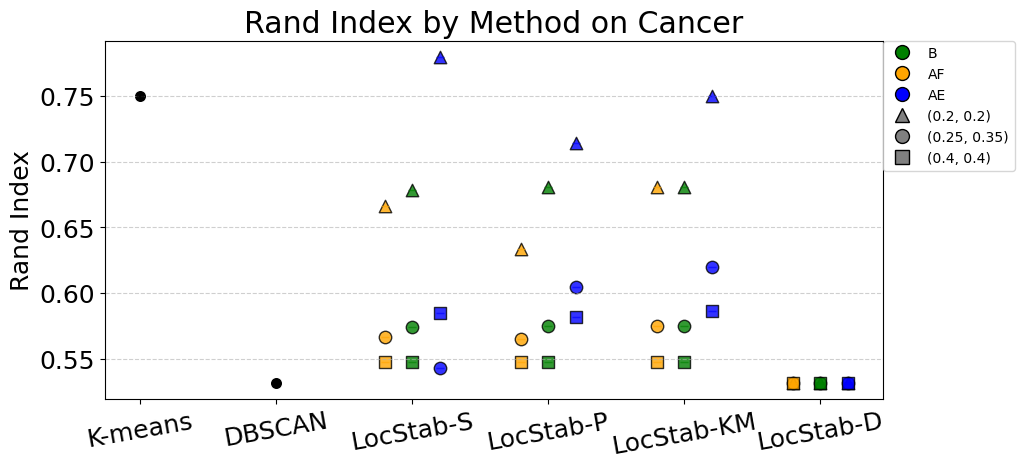

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/cluster/Cancer-Silhouette Score.png


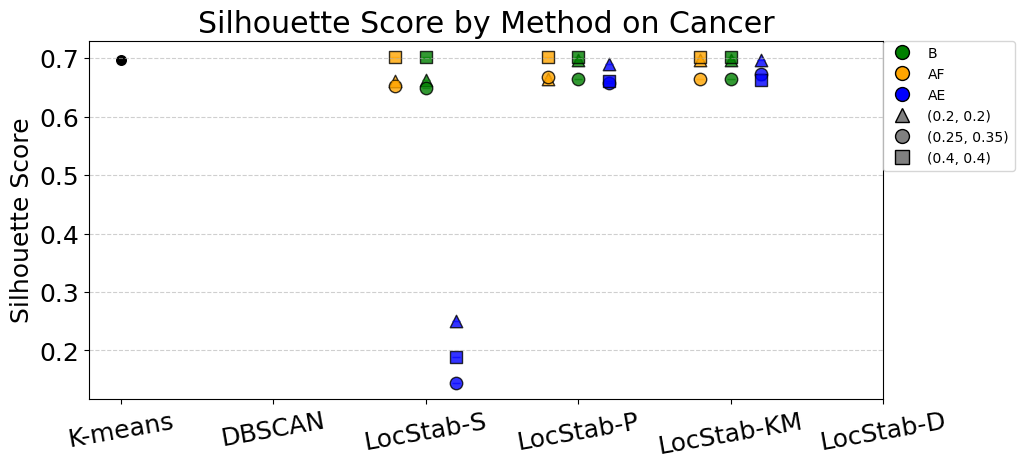

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/cluster/Iris-Rand Index.png


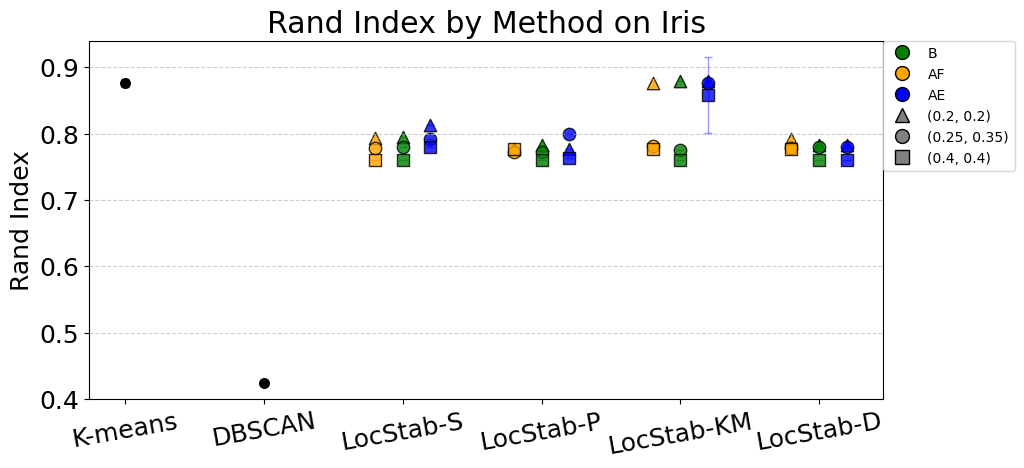

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/cluster/Iris-Silhouette Score.png


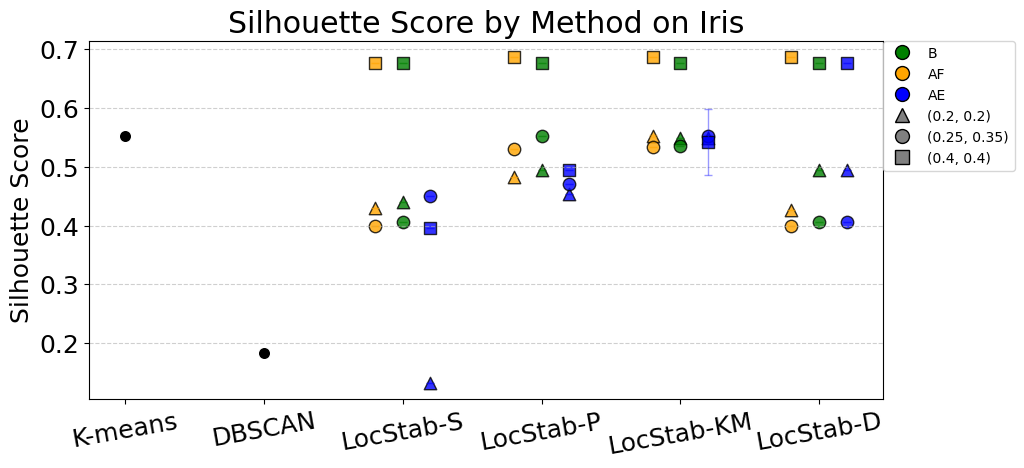

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/cluster/Moons-Rand Index.png


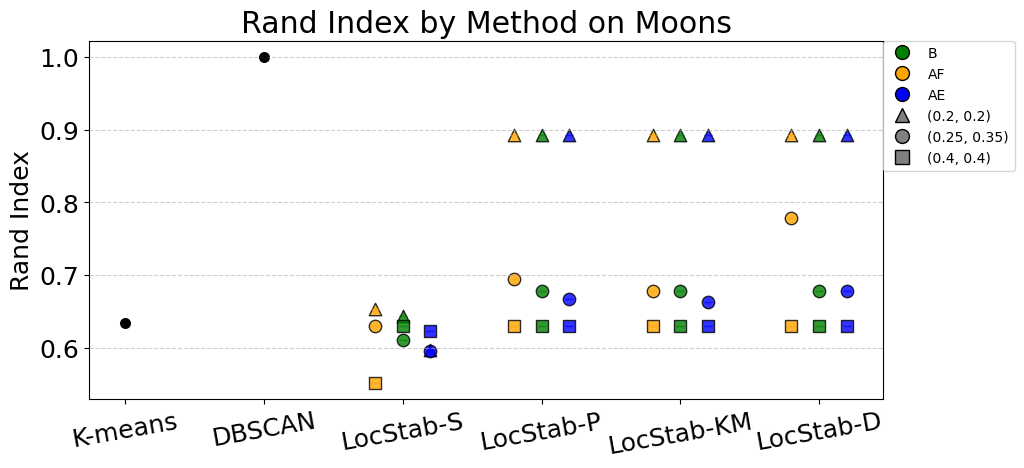

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/cluster/Moons-Silhouette Score.png


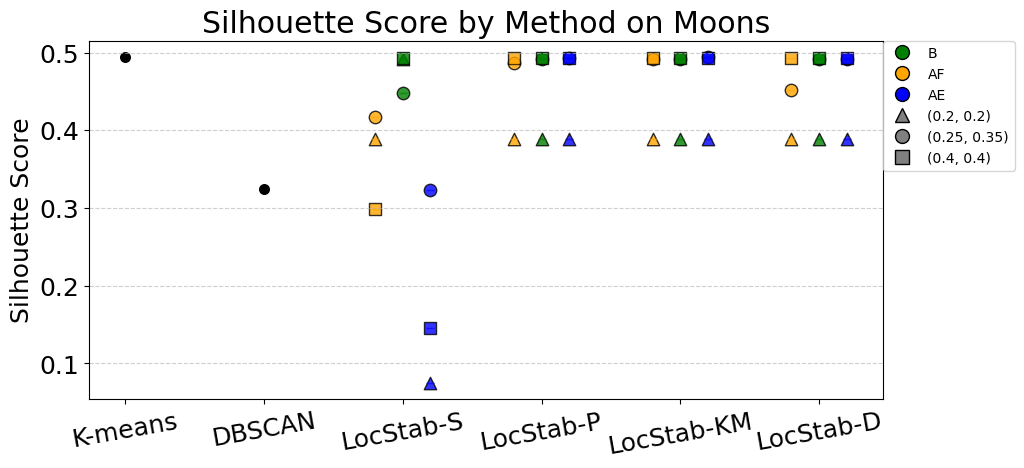

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/cluster/3 Circles-Rand Index.png


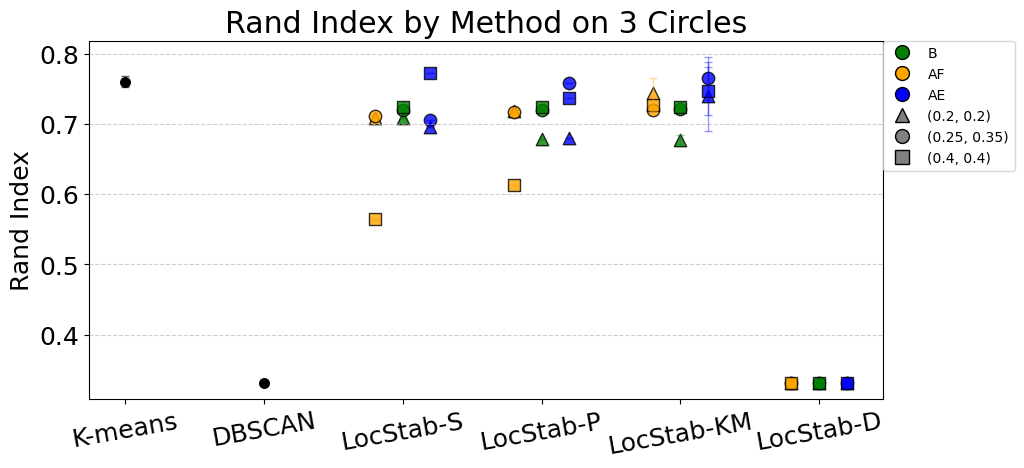

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/cluster/3 Circles-Silhouette Score.png


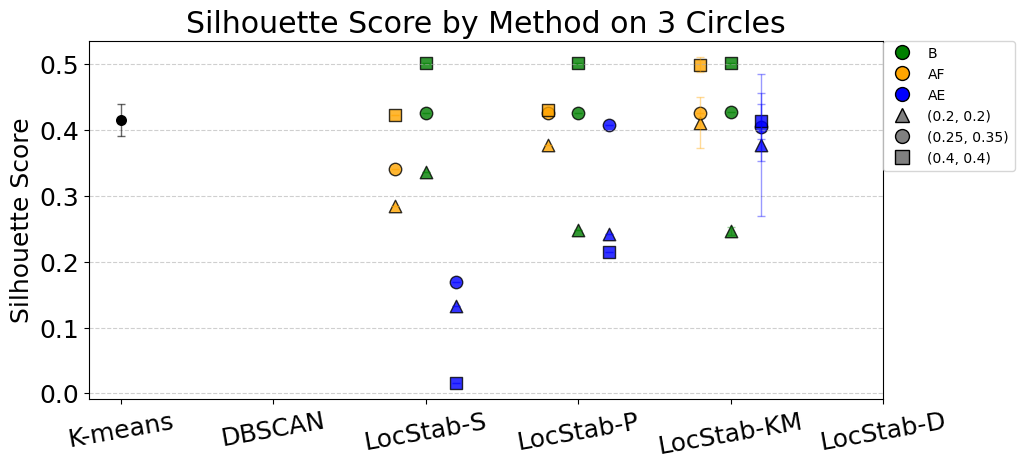

In [13]:
for df in dfs:
    df.replace("n.A.", np.nan, inplace=True)
    df.replace("My 3 Circles", "3 Circles", inplace = True)

score_cols = ['Rand Index', 'Silhouette Score']
dfs = [normalize_score_column(df, score_cols) for df in dfs]

# Then call your plotting
for Dataset in ['Cancer', 'Iris', 'Moons', '3 Circles']:
    for score in score_cols:
        plot_and_save(
            dfs, labels, Dataset, score,
            save_path=f'/Users/User/Downloads/local-popular-main-final/noylim/Stable/cluster/{Dataset}-{score}.png'
        )

In [9]:
import ast
import numpy as np
import pandas as pd

# Example: dfs = [df1, df2, df3]

all_values = []

for df in dfs:
    col = 'Rand Score with initial clustering'
    if col in df.columns:
        values = df[col].apply(
            lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('(')
            else x[0] if isinstance(x, (tuple, list))
            else float('nan')
        )
        all_values.extend(values.dropna().tolist())

# Convert to numpy array for convenience
all_values = np.array(all_values)

# Compute min, max, and average, ignoring NaNs
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
avg_val = np.nanmean(all_values)

print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Average: {avg_val}")


Min: 0.46702460850111854
Max: 1.0
Average: 0.8417155261556665


In [10]:
for i,df in enumerate(dfs):
    df.to_csv(f"/Users/User/Downloads/local-popular-main-final/noylim/Stable/cluster/data-{i}")